# Question 2a script
### Is there a relationship between procedures performed and the provider tenure?
## Entrance criteria:
The intermediate dataset for <I>Procedures and Patients</I> has been created and includes:<br>
1. removal of rows with bad provider info (null for start date)
2. removal of duplicate rows




## Initialization of the script, loading libraries, etc.

In [1]:
# import the libraries needed

import numpy as np
import pandas as pd

# graphics based libraries that will be utilized throughout
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [2]:
# import the intermediate dataset into a baseline dataframe for future use
dfPatProc = pd.read_csv(r'../data/03_processed/ProceduresPatients-20210225-ems-raw-v04.csv', 
                        na_values=['NA'])

# show the dimensions of the baseline dataframe
print(dfPatProc.shape)
# list the columns in the dataframe
dfPatProc.columns

(170072, 19)


Index(['Unnamed: 0', 'PatientId', 'FRDPersonnelID', 'PatientOutcome',
       'PatientGender', 'DispatchTime', 'FRDPersonnelGender',
       'FRDPersonnelStartDate', 'Dim_Procedure_PK', 'Procedure_Performed_Code',
       'Procedure_Performed_Description', '_PK', 'TenureMonths',
       'PatientOutcomeCode', 'PatientGenderCode', 'PatientGender_Female',
       'PatientGender_Male', 'PatientGender_Unknown (Unable to Determine)',
       'ProviderGenderCode'],
      dtype='object')

## Validate dataset is ready for evaluation

In [3]:
# check unique procedure description count
print('Procedure Description Count = '+str(dfPatProc.Procedure_Performed_Description.nunique()))

# check unique procedure code count
print('Procedure Code Count = '+str(dfPatProc.Procedure_Performed_Code.nunique()))

Procedure Description Count = 68
Procedure Code Count = 67


As there are 67 unique procedures codes and 68 unique procedure descriptions, there must be a code with two descriptions.

In [4]:
# find the procedure code(s) with more than one description
dblCheck = dfPatProc[['Procedure_Performed_Code',
                  'Procedure_Performed_Description']].groupby('Procedure_Performed_Code',).nunique()

dblCheck[(dblCheck['Procedure_Performed_Description'] > 1)]

,Procedure_Performed_Description
Procedure_Performed_Code,
427753009,2


In [5]:
# get the descriptions associated with the Procedure Code
procCode =  427753009   # is there a way to collect the value from dblCheck? 

dfPatProc[(dfPatProc['Procedure_Performed_Code'] == procCode)].Procedure_Performed_Description.unique()


array(['Airway - Supraglottic Airway (King, i-Gel)',
       'Airway - Supraglottic Airway (i-Gel, King)'], dtype=object)

Now that the descriptions have been found, they can be reset to be a common value of "Airway - Supraglottic Airway" instead of "Airway - Supraglottic Airway (King, i-Gel)" and "Airway - Supraglottic Airway (i-Gel, King)"

In [6]:
dfPatProc.replace(to_replace=['Airway - Supraglottic Airway (King, i-Gel)','Airway - Supraglottic Airway (i-Gel, King)'],
                  value='Airway - Supraglottic Airway',
                  inplace=True)

Confirm that the unique procedure count now matches the procedure code count of 67.

In [7]:
# get unique procedure count
print('Procedure Description Count = ' + str(dfPatProc.Procedure_Performed_Description.nunique()))

Procedure Description Count = 67


Next, check for any null values

In [8]:
dsNumNull=dfPatProc.isnull().sum()
dsNumNull.name='Number Rows With Nulls'
print(dsNumNull)

Unnamed: 0                                       0
PatientId                                        0
FRDPersonnelID                                   0
PatientOutcome                                   0
PatientGender                                  104
DispatchTime                                     0
FRDPersonnelGender                               0
FRDPersonnelStartDate                            0
Dim_Procedure_PK                                 0
Procedure_Performed_Code                         0
Procedure_Performed_Description                  0
_PK                                              0
TenureMonths                                     0
PatientOutcomeCode                               0
PatientGenderCode                                0
PatientGender_Female                             0
PatientGender_Male                               0
PatientGender_Unknown (Unable to Determine)      0
ProviderGenderCode                               0
Name: Number Rows With Nulls, d

PatientGender is not an attribute that will be used in this evaluation, so the null values can be ignored since in fact the column will be dropped next.

There are no null values to be addressed.

In addition to PatientGender, there are attributes that are no relevant to this evaluation.  Drop the columns that we will not be using - 'Unnamed: 0', 'PatientOutcome', 'PatientGender', 'FRDPersonnelGender', '_PK', 'PatientOutcomeCode', 'PatientGenderCode', 'PatientGender_Female', 'PatientGender_Male', 'PatientGender_Unknown (Unable to Determine)', 'ProviderGenderCode', 'Dim_Procedure_PK'

In [9]:
dfPP_working = dfPatProc.drop(columns=['Unnamed: 0', 'PatientOutcome', 'PatientGender', 'FRDPersonnelGender', '_PK', 
                                            'PatientOutcomeCode', 'PatientGenderCode', 'PatientGender_Female', 'PatientGender_Male', 
                                            'PatientGender_Unknown (Unable to Determine)', 'ProviderGenderCode','Dim_Procedure_PK'])
dfPP_working.head(5)

,PatientId,FRDPersonnelID,DispatchTime,FRDPersonnelStartDate,Procedure_Performed_Code,Procedure_Performed_Description,TenureMonths
0,479853,58D5C99E-9E01-E211-B5F5-78E7D18CFD3C,2018-01-01 00:04:06,2004-07-12,392230005,IV Start - Extremity Vein (arm or leg),161
1,479853,58D5C99E-9E01-E211-B5F5-78E7D18CFD3C,2018-01-01 00:04:06,2004-07-12,268400002,CV - ECG - 12 Lead Obtained,161
2,479853,58D5C99E-9E01-E211-B5F5-78E7D18CFD3C,2018-01-01 00:04:06,2004-07-12,268400002,CV - ECG - 12 Lead Obtained,161
3,479853,58D5C99E-9E01-E211-B5F5-78E7D18CFD3C,2018-01-01 00:04:06,2004-07-12,268400002,CV - ECG - 12 Lead Obtained,161
4,479862,32D8C99E-9E01-E211-B5F5-78E7D18CFD3C,2018-01-01 00:44:31,2006-12-11,392230005,IV Start - Extremity Vein (arm or leg),132


Before going any further, let's get some common variables set up that will make generating and evaluating the different plots easier.

In [10]:
# set up variables to be used throughout
colorMap = 'RdYlGn_r'

ticklst_30000 = [1000,2000,3000,4000,5000,10000,15000,20000,25000,30000]
xrng_30000 = [0,30000]

ticklst_7000 = [250,500,750,1000,1250,1500,1750,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000]
xrng_7000 = [0,7000]

ticklst_5000 = [100,200,300,400,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000]
xrng_5000 = [0,5000]

ticklst_3000 = [125,250,375,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000]
xrng_3000 = [0,3000]

ticklst_2500 = [125,250,375,500,750,1000,1250,1500,1750,2000,2250,2500]
xrng_2500 = [0,2500]

ticklst_1500 = [125,250,375,500,750,1000,1200,1300,1400,1500]
xrng_1500 = [0,1500]

ticklst_500 = [50,100,150,200,250,300,350,400,450,500]
xrng_500 = [0,500]

ticklst_300 = [50,100,150,200,250,300]
xrng_300 = [0,300]

ticklst_200 = [25,50,75,100,125,150,200]
xrng_200 = [0,200]

In [11]:
# set up functions to be used throughout
#need to move all of the df functions here
def BuildTenureQrtlDf(dfSource,qntl_start,qntl_end):
    dfTarget = dfSource[((dfSource['TenureYears'] >= (dfSource['TenureYears'].quantile(qntl_start))) & 
                         (dfSource['TenureYears'] < (dfSource['TenureYears'].quantile(qntl_end))))]
    return(dfTarget)


def BuildQntlTotDf(dfSource,col_code,col_desc):
    dfTarget = dfSource.groupby([col_code,col_desc])[["Procedure_Count"]].sum().reset_index()
    return(dfTarget)

## Initial evaluation of Tenure in the dataset

Since we will be looking at the tenure throughout, we need to take a preliminary look at the dataset and be sure there are no inconsitencies with respect to the attribute.  Given that there are over 170,000 records in the dataset, the number of bins utilized initially in the histogram will be 15 in order to see any macro issues with respect to tenure.

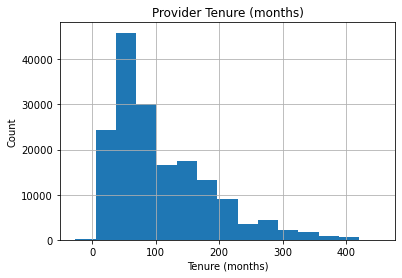

In [12]:
# histogram of tenure in months
fig,ax=plt.subplots()
ax.hist(x=dfPP_working['TenureMonths'], bins = 15)
ax.set_xlabel('Tenure (months)')
ax.set_ylabel('Count')
ax.set_title('Provider Tenure (months)')
ax.ticklabel_format(style='plain')
ax.grid()
#plt.xticks(rotation=45)
plt.show()

In [13]:
dfPP_working[['TenureMonths']].describe()

,TenureMonths
count,170072.000000
mean,106.863746
std,77.888722
min,-27.000000
25%,49.000000
50%,82.000000
75%,152.000000
max,453.000000


Confirmed by the descriptive statistics of the Tenure attribute in the dfPP_working dataframe, there is evidence of negative tenures present - aka "time travelers".  Since the calculation for tenure is based on the difference between the provider start date and dispatch date attributes, having a negative tenure is possible but the reality does not make sense.

How many "time traveler" records are there?

In [14]:
# extract the records with a time traveler for a provider and put them in a new dataset (tenure is negative)
dfTimeTravelers=dfPP_working[(dfPP_working["TenureMonths"] < 0)]

print("dfTimeTravelers -> {}".format(len(dfTimeTravelers)))

dfTimeTravelers -> 21


Identify the providers that are time traveling in these 21 records.

In [15]:
# print the provider id for the time travelers
print(dfTimeTravelers.FRDPersonnelID.drop_duplicates())

532       DDB27180-A778-4655-8FC6-F9511F36175B
2380      3FD2C99E-9E01-E211-B5F5-78E7D18CFD3C
9904      6FB584B8-F37D-45E3-8FCC-C820ACF46816
64027     86D2C99E-9E01-E211-B5F5-78E7D18CFD3C
169822    380F3265-F26A-4EF1-A1AD-5D8A9E41D12A
Name: FRDPersonnelID, dtype: object


Remove the time travelers from the working dataset.  Since there are only 21 records, removing the time travelers will only have an impact on the Tenure statistics, but will not have a significant impact on the overall evalution.

In [16]:
# create a new dataframe that does not include the time travelers and will serve as the baseline dataframe
dfPPBaseline = dfPP_working[(dfPP_working['TenureMonths'] >= 0)]

print("dfPPBaseline -> {}".format(len(dfPPBaseline)))

dfPPBaseline -> 170051


In [17]:
# show the difference in the count of records now that the time travelers have been dropped
print("dfPP_working -> {}\ndfPPBaseline -> {}".format(len(dfPP_working),len(dfPPBaseline)))
print("record difference -> {}".format(len(dfPP_working)-len(dfPPBaseline)))

dfPP_working -> 170072
dfPPBaseline -> 170051
record difference -> 21


Rerun the baseline statistics for Tenure after removing the Time Travelers to confirm that the minimum is now 0.

In [18]:
dfPPBaseline[['TenureMonths']].describe()

,TenureMonths
count,170051.000000
mean,106.878683
std,77.881907
min,0.000000
25%,49.000000
50%,82.000000
75%,152.000000
max,453.000000


Add a column to hold the value of tenure in years.

Divide the TenureMonths by 12 and drop the remainder.
__Calculation of Tenure in Months results in value that represents number of completed years of service.  (e.g. 35 months -> 2 years, 36 months -> 3 years)__

In [19]:
dfPPBaseline.loc[:,"TenureYears"]=np.floor(dfPPBaseline["TenureMonths"]/12)
dfPPBaseline.shape

C:\Users\gecko\Anaconda3\envs\emspe\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\gecko\Anaconda3\envs\emspe\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


(170051, 8)

## Initial evaluation of Procedures within the dataset

In [20]:
# check out the value counts for the different procedures
dfPPBaseline[["Procedure_Performed_Description","Procedure_Performed_Code"]].value_counts()

Procedure_Performed_Description             Procedure_Performed_Code
CV - ECG - 12 Lead Obtained                 268400002                   66972
IV Start - Extremity Vein (arm or leg)      392230005                   59835
Electrocardiographic monitoring             46825001                     4755
MS - Cervical Spinal Restriction of Motion  398041008                    4693
Assess - Assessment of Patient              422618004                    4192
                                                                        ...  
Laryngoscopy - Indirect                     673005                          4
Intubation - Existing Tracheostomy Stoma    232685002                       3
Infectious - Decontamination of Patient     409530006                       3
Enviro - Hypothermia Induction Therapy      430189000                       3
Cricothyrotomy - Needle                     232689008                       3
Length: 67, dtype: int64

In [21]:
# use the listing to build a Procedures listing that is ordered from largest count to smallest
procVC = dfPPBaseline[["Procedure_Performed_Description","Procedure_Performed_Code"]].value_counts()
dfProcList = pd.DataFrame(procVC)
dfProcList.reset_index(inplace=True)
dfProcList.columns=['Procedure_Description','Procedure_Performed_Code','Procedure_Total']
dfProcList.set_index(keys=['Procedure_Description'])
dfProcList

,Procedure_Description,Procedure_Performed_Code,Procedure_Total
0,CV - ECG - 12 Lead Obtained,268400002,66972
1,IV Start - Extremity Vein (arm or leg),392230005,59835
2,Electrocardiographic monitoring,46825001,4755
3,MS - Cervical Spinal Restriction of Motion,398041008,4693
4,Assess - Assessment of Patient,422618004,4192
...,...,...,...
62,Laryngoscopy - Indirect,673005,4
63,Intubation - Existing Tracheostomy Stoma,232685002,3
64,Infectious - Decontamination of Patient,409530006,3
65,Enviro - Hypothermia Induction Therapy,430189000,3


In [22]:
# save the overall procedure count to a variable
proc_count_all = len(dfProcList)
#print(proc_count_all)

# create a procedure order array
ProcOrder = np.array(dfProcList['Procedure_Description'])
ProcOrder

array(['CV - ECG - 12 Lead Obtained',
       'IV Start - Extremity Vein (arm or leg)',
       'Electrocardiographic monitoring',
       'MS - Cervical Spinal Restriction of Motion',
       'Assess - Assessment of Patient',
       'Assess - Blood Glucose Level (BGL)',
       'CV - ECG - Limb Lead Monitoring', 'Assess - Capnography (ETCO2)',
       'IO Start - Intraosseous Access',
       'MS - Full Spinal Restriction of Motion', 'Wound Care - General',
       'CV - Defibrillation - Manual', 'MS - Splinting - General',
       'Resp - Assist Ventilation - BVM Via Mask',
       'Resp - Assisted Ventilation - CPAP',
       'Assess - Capnograph waveform', 'CPR - Manual',
       'Airway - Supraglottic Airway',
       'Enviro - Patient Cooling (Cold Pack or General)',
       'CPR - Mechanical Device', 'IV Start - EJ (External Jugular Vein)',
       'Airway - Oropharyngeal Insertion',
       'Wound Care - Dressing - Pressure Dressing',
       'Airway - Nasopharyngeal Insertion', 'Airway - Clear

Run a baseline histogram of procedures performed.

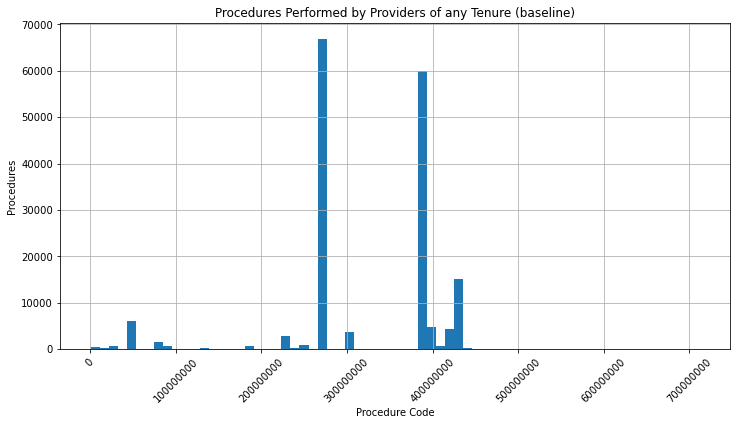

In [23]:
# histogram of procedures performed using original data
fig,ax=plt.subplots(figsize=(12,6))
ax.hist(x=dfPPBaseline['Procedure_Performed_Code'], bins=len(dfProcList))
ax.set_xlabel('Procedure Code')
ax.set_ylabel('Procedures')
ax.set_title('Procedures Performed by Providers of any Tenure (baseline)')
ax.ticklabel_format(style='plain')
ax.grid()
plt.xticks(rotation=45)
plt.show()

Run a baseline pie chart to better see the distribution of the procedures by procedure name.

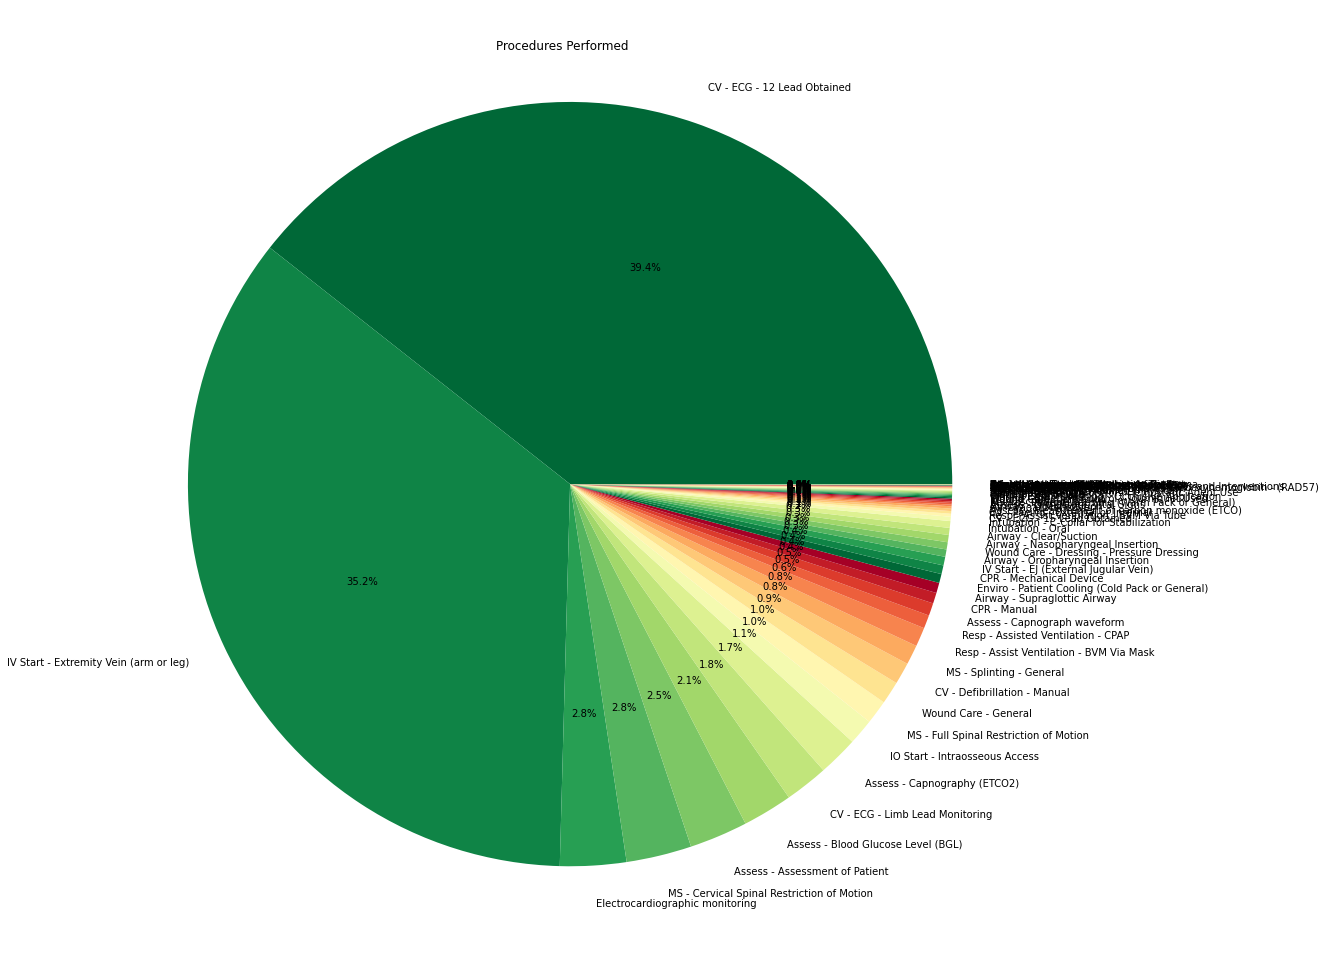

In [24]:
# build the labels and counts to display
# based on https://blog.algorexhealth.com/2018/03/almost-10-pie-charts-in-10-python-libraries/
source_labels = dfProcList.Procedure_Description
source_counts = dfProcList.Procedure_Total

# select the colors to use
cmap = plt.get_cmap('RdYlGn_r')
colors = [cmap(i) for i in np.linspace(0, 1, 18)]

fig,ax=plt.subplots(figsize=(14,14))
fig.tight_layout()
fig.subplots_adjust(top=1.05)
fig.suptitle("Procedures Performed")

ax.pie(x=source_counts,labels=source_labels,autopct='%1.1f%%', colors=colors)
#ax.set_title("Procedures Performed")
plt.show()

With so many procedures ocurring very few times, let's group them together so a more readable chart is possible

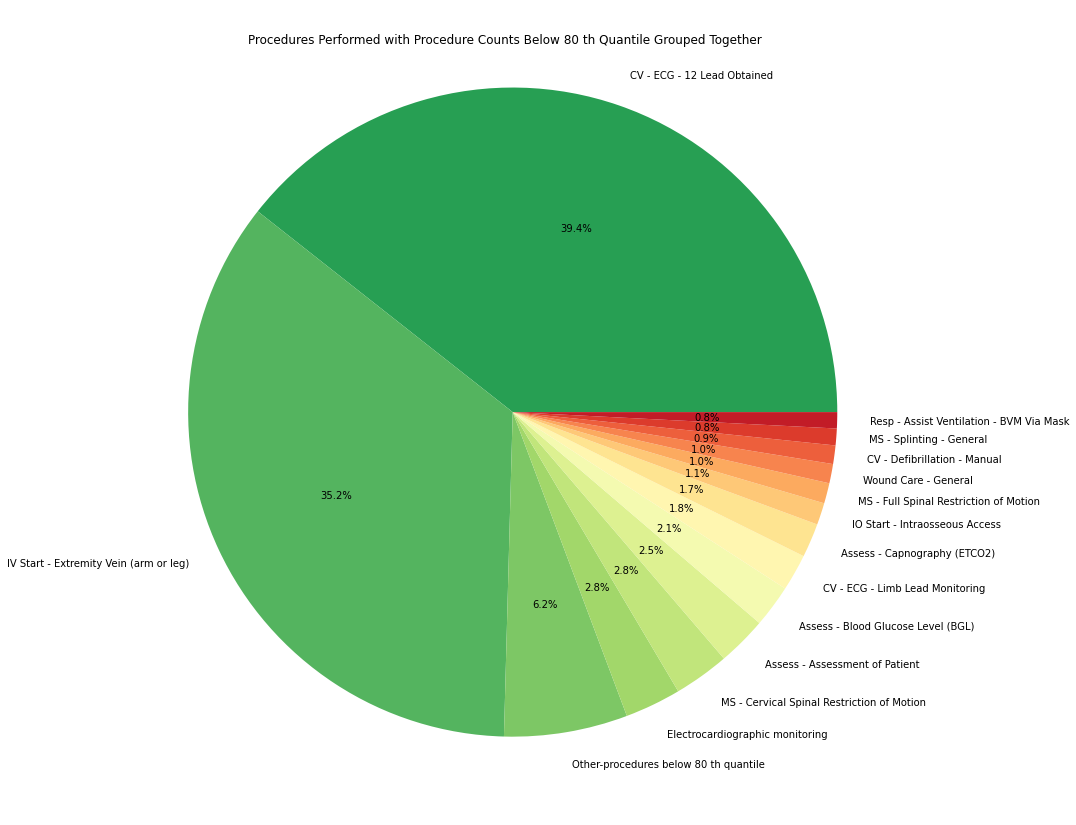

In [25]:
def group_lower_ranking_values(qntl_val,column,df_base):
    # based on https://blog.algorexhealth.com/2018/03/almost-10-pie-charts-in-10-python-libraries/
    col_sum = df_base.groupby(column).agg('sum')
    pct_value = col_sum[lambda df: df.columns[0]].quantile(qntl_val/100)
    values_below_pct_value = col_sum[lambda df: df.columns[0]].loc[lambda s: s < pct_value].index.values
    def fix_values(row):
        if row[column] in values_below_pct_value:
            row[column] = " ".join(['Other-procedures below',str(qntl_val),'th quantile'])
        return row 
    proc_grouped = df_base.apply(fix_values, axis=1).groupby(column).agg('sum')
    return proc_grouped

qntl_val = 80
dfProcGrpPie = group_lower_ranking_values(qntl_val,'Procedure_Description',dfProcList[['Procedure_Description','Procedure_Total']]).sort_values("Procedure_Total", ascending=False).reset_index()

# build the labels and counts to display
source_labels = dfProcGrpPie.Procedure_Description
source_counts = dfProcGrpPie.Procedure_Total
fig,ax=plt.subplots(figsize=(12,12))
fig.tight_layout()
fig.subplots_adjust(top=1.05)
fig.suptitle(" ".join(["Procedures Performed with Procedure Counts Below",str(qntl_val),"th Quantile Grouped Together"]))

ax.pie(x=source_counts,labels=source_labels,autopct='%1.1f%%', colors=colors[2:18])
#ax.set_title(" ".join(["Procedures Performed with Procedure Counts Below",str(qntl_val),"th Quantile Grouped Together"]))
plt.show()

Using the dfProcList dataframe, are there any descriptive statistics that can be seen with respect to the Procedure Totals?

In [26]:
dfProcList[['Procedure_Total']].describe()

,Procedure_Total
count,67.000000
mean,2538.074627
std,10834.920102
min,3.000000
25%,30.000000
50%,106.000000
75%,755.500000
max,66972.000000


## Evaluate Procedures and Tenure together

See if running a correlation plot reveals any insight

In [27]:
dfPPBaseline.corr()

,PatientId,Procedure_Performed_Code,TenureMonths,TenureYears
PatientId,1.000000,0.112333,0.049640,0.049053
Procedure_Performed_Code,0.112333,1.000000,0.006108,0.005889
TenureMonths,0.049640,0.006108,1.000000,0.999021
TenureYears,0.049053,0.005889,0.999021,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

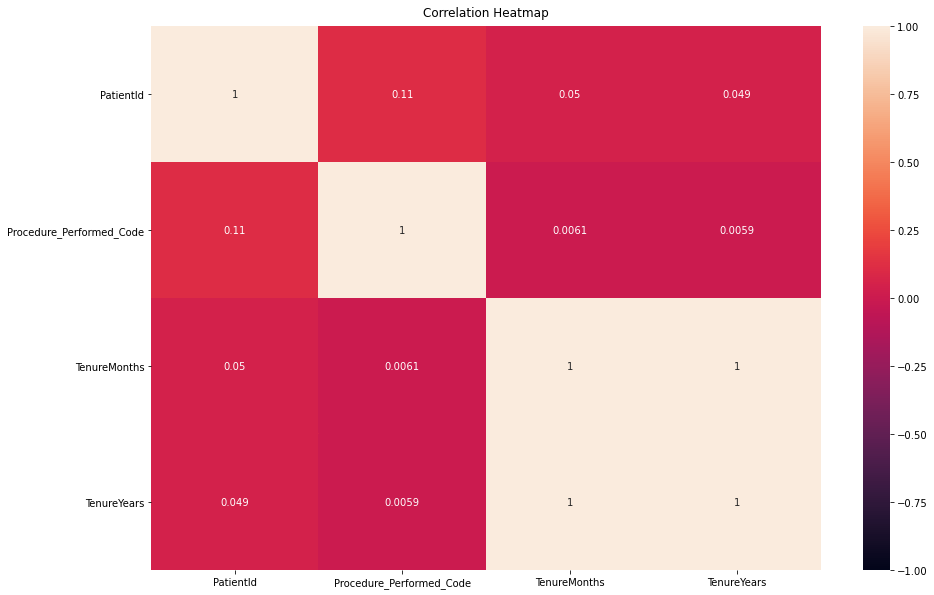

In [28]:
plt.figure(figsize=(15,10))
heatmap=sns.heatmap(dfPPBaseline.corr(),vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12},pad=10)

As would be expected the TenureMonths and TenureYears are correlated since one is derived from the other.  However, with correlation coefficients so low for tenure and procedure pairings, there do not appear to be any relation between Tenure and Procedures performed.

However, we can still compare the two attributes via plots and visualizations to see if there are any other relationships or indicators to find.

In [29]:
# create a procedure order array
ProcOrder = np.array(dfProcList['Procedure_Description'])
#ProcOrder

Create a pivot-like dataframe using tenure, procedure code and procedure description to get a procedures performed count break down by tenure and procedure in a single dataframe.

In [30]:
dfPP_pvt_mth = dfPPBaseline.groupby(['TenureMonths',
                                     'Procedure_Performed_Code',
                                     'Procedure_Performed_Description']).size().to_frame(name='Procedure_Count').reset_index()

dfPP_pvt_mth.shape

(8793, 4)

In [31]:
# show the first two rows of the dataset
dfPP_pvt_mth.head(2)

,TenureMonths,Procedure_Performed_Code,Procedure_Performed_Description,Procedure_Count
0,0,268400002,CV - ECG - 12 Lead Obtained,1
1,0,302789003,Assess - Blood Glucose Level (BGL),1


In [32]:
# show the last two rows of the dataset
dfPP_pvt_mth.tail(2)

,TenureMonths,Procedure_Performed_Code,Procedure_Performed_Description,Procedure_Count
8791,440,425447009,Resp - Assist Ventilation - BVM Via Mask,2
8792,453,392230005,IV Start - Extremity Vein (arm or leg),1


In [33]:
dfPP_pvt_mth.columns

Index(['TenureMonths', 'Procedure_Performed_Code',
       'Procedure_Performed_Description', 'Procedure_Count'],
      dtype='object')

In order to see the distribution of procedures against tenure, generate a hex bin plot using tenure, procedure code, and procedure count from dfPatProc_pvt as the x, y and C values, respectively.

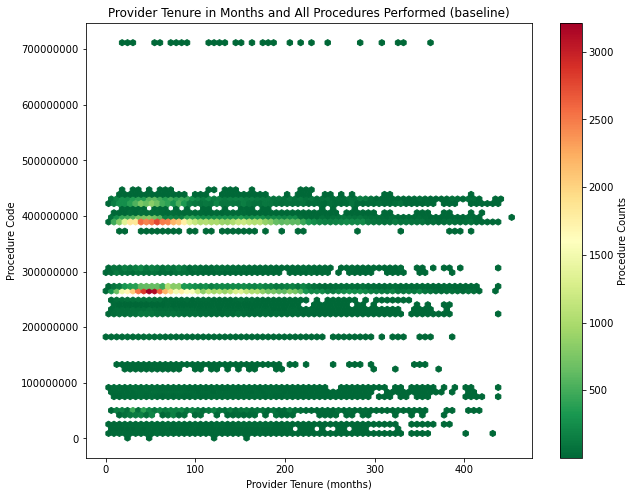

In [34]:
fig, axs = plt.subplots(figsize=(10, 8))
ax = axs
hb1 = ax.hexbin(    x = dfPP_pvt_mth["TenureMonths"], 
                    y = dfPP_pvt_mth["Procedure_Performed_Code"], 
                    C = dfPP_pvt_mth["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=75, 
                    cmap="RdYlGn_r"
                    #sharex=False)
               )
ax.set_title("Provider Tenure in Months and All Procedures Performed (baseline)")
ax.set_xlabel("Provider Tenure (months)")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

Using dfPP_pvt_mth, generate descriptive statistics about the tenure, procedure count, and procedure description attributes.

In [35]:
dfPP_pvt_mth[['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,8793.000000,8793.000000
mean,152.901285,19.339361
std,102.830456,66.260006
min,0.000000,1.000000
25%,66.000000,1.000000
50%,137.000000,3.000000
75%,220.000000,7.000000
max,453.000000,697.000000


In [36]:
dfPP_pvt_mth[['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,8793
unique,67
top,IV Start - Extremity Vein (arm or leg)
freq,421


Do a quick check to be sure that that top ten totals calculated in dfProcList still match those pulled from dfPP_pvt_mth

In [37]:
dfPP_pvt_mth.groupby(["Procedure_Performed_Code",
                        "Procedure_Performed_Description"])[["Procedure_Count"]].sum().nlargest(10,["Procedure_Count"])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,66972
392230005,IV Start - Extremity Vein (arm or leg),59835
46825001,Electrocardiographic monitoring,4755
398041008,MS - Cervical Spinal Restriction of Motion,4693
422618004,Assess - Assessment of Patient,4192
302789003,Assess - Blood Glucose Level (BGL),3590
428803005,CV - ECG - Limb Lead Monitoring,3114
425543005,Assess - Capnography (ETCO2),2876
430824005,IO Start - Intraosseous Access,1857


Rerun the Tenure histogram to get an idea of the most frequent mnthly tenure values.

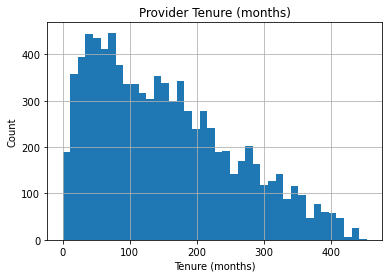

In [38]:
#dfPP_pvt_mth.hist(column='TenureMonths', bins=40)
fig,ax=plt.subplots()
ax.hist(x=dfPP_pvt_mth['TenureMonths'], bins = 40)
ax.set_xlabel('Tenure (months)')
ax.set_ylabel('Count')
ax.set_title('Provider Tenure (months)')
ax.ticklabel_format(style='plain')
ax.grid()
#plt.xticks(rotation=45)
plt.show()

This histogram, taken with the mean of Tenure, show that most of the providers are found between 0 and 100 months.

In [39]:
# create a dataframe for repeated use in analysis including only records with 100 or less months of tenure
dfPP_pvt_mth_lte100 = dfPP_pvt_mth[(dfPP_pvt_mth['TenureMonths'] <= 100)]
dfPP_pvt_mth_lte100.shape

(3361, 4)

Generate the respective descriptive statistics.

In [40]:
dfPP_pvt_mth_lte100[['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,3361.000000,3361.000000
mean,52.940494,29.905980
std,26.465938,94.333732
min,0.000000,1.000000
25%,31.000000,2.000000
50%,53.000000,4.000000
75%,75.000000,11.000000
max,100.000000,697.000000


What are the top 10 procedures by count for procedures performed by providers with 100 or less months of tenure?

In [41]:
dfPP_pvt_mth_lte100.groupby(['Procedure_Performed_Code',
     'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,39043
392230005,IV Start - Extremity Vein (arm or leg),33944
422618004,Assess - Assessment of Patient,3596
46825001,Electrocardiographic monitoring,3035
398041008,MS - Cervical Spinal Restriction of Motion,2621
302789003,Assess - Blood Glucose Level (BGL),2571
425543005,Assess - Capnography (ETCO2),1998
428803005,CV - ECG - Limb Lead Monitoring,1966
430824005,IO Start - Intraosseous Access,1121


The mean of the tenure values for those providers with 100 months or less, is 52.9 months.

What are the top 10 procedures by count for procedures performed by providers with 52 or 53 months (mean = 52.9) of tenure?

In [42]:
dfPP_pvt_mth[(dfPP_pvt_mth['TenureMonths'] >= 52) & 
             (dfPP_pvt_mth['TenureMonths'] <= 53)].groupby(['Procedure_Performed_Code', 
                    'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,1221
392230005,IV Start - Extremity Vein (arm or leg),925
422618004,Assess - Assessment of Patient,164
46825001,Electrocardiographic monitoring,112
428803005,CV - ECG - Limb Lead Monitoring,86
425543005,Assess - Capnography (ETCO2),84
398041008,MS - Cervical Spinal Restriction of Motion,81
302789003,Assess - Blood Glucose Level (BGL),58
225358003,Wound Care - General,39


Evaluate influence of highest procedure counts

Start with the two highest procedure counts overall and how they influence the hexbin plots

How does the hexbin plot change when the 2 highest procedure counts are not plotted?

In [43]:
dfPP_pvt_mth.groupby(["Procedure_Performed_Code",
                        "Procedure_Performed_Description"])[["Procedure_Count"]].sum().nlargest(2,["Procedure_Count"])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,66972
392230005,IV Start - Extremity Vein (arm or leg),59835


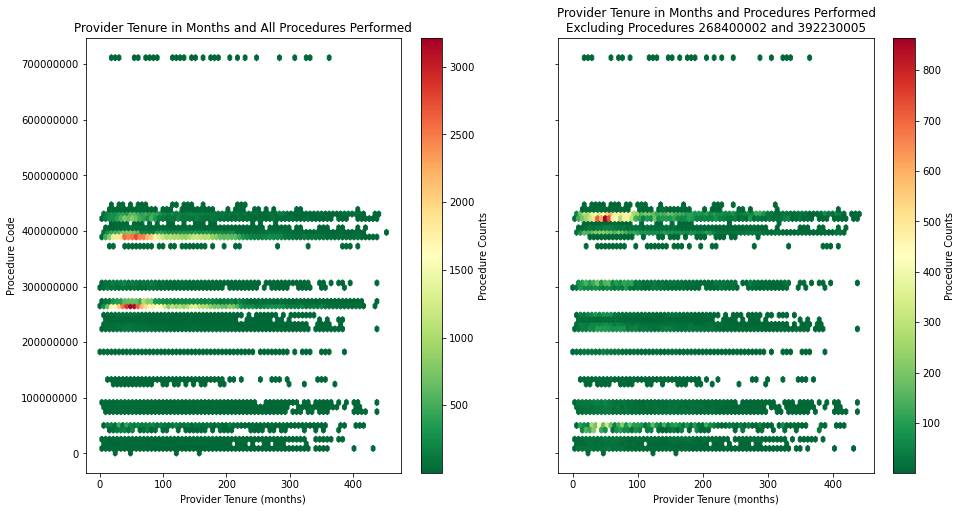

In [44]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(14, 8))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0]
hb1 = ax.hexbin(    x = dfPP_pvt_mth["TenureMonths"], 
                    y = dfPP_pvt_mth["Procedure_Performed_Code"], 
                    C = dfPP_pvt_mth["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=75, 
                    cmap="RdYlGn_r", 
               )
#ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.set_title("Provider Tenure in Months and All Procedures Performed")
ax.set_xlabel("Provider Tenure (months)")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

ax = axs[1]
hb2 = ax.hexbin(    x = dfPP_pvt_mth[(dfPP_pvt_mth['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_mth['Procedure_Performed_Code'] != 392230005)]["TenureMonths"],
                    y = dfPP_pvt_mth[(dfPP_pvt_mth['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_mth['Procedure_Performed_Code'] != 392230005)]["Procedure_Performed_Code"],
                    C = dfPP_pvt_mth[(dfPP_pvt_mth['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_mth['Procedure_Performed_Code'] != 392230005)]["Procedure_Count"],
                    reduce_C_function=np.sum,
                    gridsize=75,
                    cmap="RdYlGn_r",
               )
#ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.set_title("Provider Tenure in Months and Procedures Performed\nExcluding Procedures 268400002 and 392230005")
ax.set_xlabel("Provider Tenure (months)")
cb = fig.colorbar(hb2, ax=ax)
cb.set_label('Procedure Counts')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

In addition to the Procedure Count scale changing, the "hot spots" of color change.

### Evaluate procedures and tenure again using the yearly tenure values

Create a new pivot dataframe using TenureYears instead of TenureMonths

In [45]:
dfPP_pvt_yr = dfPPBaseline.groupby(['TenureYears',
                                    'Procedure_Performed_Code',
                                    'Procedure_Performed_Description']).size().to_frame(name='Procedure_Count').reset_index()

dfPP_pvt_yr.shape

(1508, 4)

In [46]:
# show the first two rows of the new pivot dataframe
dfPP_pvt_yr.head(2)

,TenureYears,Procedure_Performed_Code,Procedure_Performed_Description,Procedure_Count
0,0.0,7443007,Airway - Oropharyngeal Insertion,23
1,0.0,18590009,CV - Pacing - External or Internal,1


In [47]:
# show the last two rows of the new pivot dataframe
dfPP_pvt_yr.tail(2)

,TenureYears,Procedure_Performed_Code,Procedure_Performed_Description,Procedure_Count
1506,36.0,428803005,CV - ECG - Limb Lead Monitoring,8
1507,37.0,392230005,IV Start - Extremity Vein (arm or leg),1


In [48]:
dfPP_pvt_yr[['TenureYears','Procedure_Count']].describe()

,TenureYears,Procedure_Count
count,1508.000000,1508.000000
mean,14.310345,112.765915
std,9.403890,559.910856
min,0.000000,1.000000
25%,6.000000,2.000000
50%,13.000000,7.000000
75%,21.000000,33.000000
max,37.000000,7741.000000


In [49]:
dfPP_pvt_yr.groupby(["Procedure_Performed_Code",
                        "Procedure_Performed_Description"])[["Procedure_Count"]].sum().nlargest(10,["Procedure_Count"])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,66972
392230005,IV Start - Extremity Vein (arm or leg),59835
46825001,Electrocardiographic monitoring,4755
398041008,MS - Cervical Spinal Restriction of Motion,4693
422618004,Assess - Assessment of Patient,4192
302789003,Assess - Blood Glucose Level (BGL),3590
428803005,CV - ECG - Limb Lead Monitoring,3114
425543005,Assess - Capnography (ETCO2),2876
430824005,IO Start - Intraosseous Access,1857


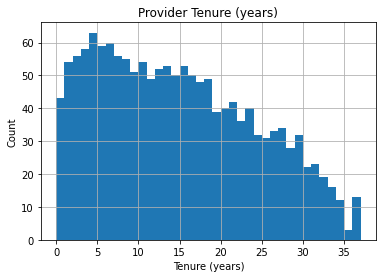

In [50]:
fig,ax=plt.subplots()
ax.hist(x=dfPP_pvt_yr['TenureYears'], bins = int(dfPP_pvt_yr['TenureYears'].max()))
ax.set_xlabel('Tenure (years)')
ax.set_ylabel('Count')
ax.set_title('Provider Tenure (years)')
ax.ticklabel_format(style='plain')
ax.grid()
#plt.xticks(rotation=45)
plt.show()

The high point is now identified as 4 yrs, which corresponds to the previously identified high point of 52-53 months.

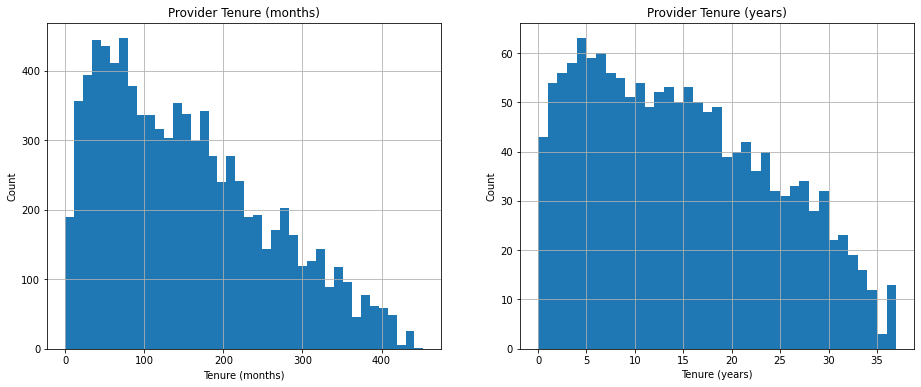

In [51]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)

ax = axs[0]
ax.hist(x=dfPP_pvt_mth['TenureMonths'], bins = 40)
ax.set_xlabel('Tenure (months)')
ax.set_ylabel('Count')
ax.set_title('Provider Tenure (months)')
ax.ticklabel_format(style='plain')
ax.grid()
#plt.xticks(rotation=45)
#plt.show()

ax = axs[1]
ax.hist(x=dfPP_pvt_yr['TenureYears'], bins = int(dfPP_pvt_yr['TenureYears'].max()))
ax.set_xlabel('Tenure (years)')
ax.set_ylabel('Count')
ax.set_title('Provider Tenure (years)')
ax.ticklabel_format(style='plain')
ax.grid()
#plt.xticks(rotation=45)

plt.show()

In [52]:
# show the count of rows assigned to each year
#dfPP_pvt_yr.groupby(['TenureYears']).size().to_frame(name='Count')

### Build a category listing for procedures, so can group similar procedures together later on


categories: 'Exclude','Airway - Clear/Suction','Airway - Foreign Body Removal','BLS Airway','Airway - Supraglottic Airway', 'Assessment','Behavior - Restraint Applied','CPR','Cricothyrotomy','CV - Cardioversion', 'CV - Defibrillation - Manual','CV - ECG','CV - Pacing','CV - Vagal Maneuver','Decompression - Chest Decompression', 'Enviro - Patient Cooling','Enviro - Patient Warming','Gen''l - Irrigation - Eye(s)','Intubation - Existing Tracheostomy Stoma', 'Intubation/Laryngoscopy','IO Start - Intraosseous Access','IV Start - Vein','MS - Restriction of Motion','MS - Splinting', 'Pelvic splint device','Resp - Assist Ventilation','Resp - Assisted Ventilation - CPAP','Warming - Use of IV/IO Fluid Warmer', 'Wound - Bleeding Control','Wound Care - Dressing - Occlusive Application','CV - ECG - Limb Lead Monitoring'


In [53]:
# review current dfProcList
dfProcList

,Procedure_Description,Procedure_Performed_Code,Procedure_Total
0,CV - ECG - 12 Lead Obtained,268400002,66972
1,IV Start - Extremity Vein (arm or leg),392230005,59835
2,Electrocardiographic monitoring,46825001,4755
3,MS - Cervical Spinal Restriction of Motion,398041008,4693
4,Assess - Assessment of Patient,422618004,4192
...,...,...,...
62,Laryngoscopy - Indirect,673005,4
63,Intubation - Existing Tracheostomy Stoma,232685002,3
64,Infectious - Decontamination of Patient,409530006,3
65,Enviro - Hypothermia Induction Therapy,430189000,3


In [54]:
proc_cat_idx = np.arange(0,30)
dfProcCat = pd.DataFrame({"ProcedureCategory" : ['Exclude','Airway - Clear/Suction','Airway - Foreign Body Removal',
                                                 'BLS Airway','Airway - Supraglottic Airway', 'Assessment',
                                                 'Behavior - Restraint Applied','CPR','Cricothyrotomy',
                                                 'CV - Cardioversion','CV - Defibrillation - Manual','CV - ECG',
                                                 'CV - Pacing','CV - Vagal Maneuver','Chest Decompressions',
                                                 'Enviro - Patient Cooling','Enviro - Patient Warming',
                                                 'Gen''l - Irrigation - Eye(s)',
                                                 'Intubation - Existing Tracheostomy Stoma','Intubation/Laryngoscopy',
                                                 'IO Start - Intraosseous Access','IV Start - Vein',
                                                 'MS - Restriction of Motion','MS - Splinting','Pelvic splint device',
                                                 'Resp - Assist Ventilation','Resp - Assisted Ventilation - CPAP',
                                                 'Warming - Use of IV/IO Fluid Warmer','Wound - Bleeding Control',
                                                 'Wound Care - Dressing'],
                         "ProcedureCatCode": proc_cat_idx},
                        index = proc_cat_idx)
# assign the appropriate procedure category code to the list of procedures
dfProcList["ProcedureCatCode"]=[11,21,0,22,5,5,11,5,20,22,0,10,23,25,26,5,7,4,15,7,21,3,28,3,1,19,0,11,25,12,
                                5,13,0,0,16,0,0,28,29,0,0,24,28,0,0,6,17,14,23,9,5,6,19,0,2,0,0,0,27,28,
                                0,8,19,18,0,0,8]
# now that dfProcList includes the procedure category keys/index values, merge the two dataframes to also include the labels
dfProcList=pd.merge(dfProcList, dfProcCat,on="ProcedureCatCode",how="left")
dfProcList

,Procedure_Description,Procedure_Performed_Code,Procedure_Total,ProcedureCatCode,ProcedureCategory
0,CV - ECG - 12 Lead Obtained,268400002,66972,11,CV - ECG
1,IV Start - Extremity Vein (arm or leg),392230005,59835,21,IV Start - Vein
2,Electrocardiographic monitoring,46825001,4755,0,Exclude
3,MS - Cervical Spinal Restriction of Motion,398041008,4693,22,MS - Restriction of Motion
4,Assess - Assessment of Patient,422618004,4192,5,Assessment
...,...,...,...,...,...
62,Laryngoscopy - Indirect,673005,4,19,Intubation/Laryngoscopy
63,Intubation - Existing Tracheostomy Stoma,232685002,3,18,Intubation - Existing Tracheostomy Stoma
64,Infectious - Decontamination of Patient,409530006,3,0,Exclude
65,Enviro - Hypothermia Induction Therapy,430189000,3,0,Exclude


In [55]:
dfPP_pvt_yr_cat = pd.merge(dfPP_pvt_yr,dfProcList[["Procedure_Performed_Code","ProcedureCatCode","ProcedureCategory"]]
                          ,on='Procedure_Performed_Code',how="left")

In [56]:
dfPP_pvt_yr_cat

,TenureYears,Procedure_Performed_Code,Procedure_Performed_Description,Procedure_Count,ProcedureCatCode,ProcedureCategory
0,0.0,7443007,Airway - Oropharyngeal Insertion,23,3,BLS Airway
1,0.0,18590009,CV - Pacing - External or Internal,1,12,CV - Pacing
2,0.0,20655006,Wound - Bleeding Control - Tourniquet Used,2,28,Wound - Bleeding Control
3,0.0,22206003,Wound Care - Dressing - Occlusive Application,2,29,Wound Care - Dressing
4,0.0,26906007,Wound Care - Dressing - Pressure Dressing,4,28,Wound - Bleeding Control
...,...,...,...,...,...,...
1503,36.0,422618004,Assess - Assessment of Patient,4,5,Assessment
1504,36.0,425058005,Assess - Orthostatic Vital Signs,3,0,Exclude
1505,36.0,425447009,Resp - Assist Ventilation - BVM Via Mask,3,25,Resp - Assist Ventilation
1506,36.0,428803005,CV - ECG - Limb Lead Monitoring,8,11,CV - ECG


In [57]:
# use the listing to build a Procedures Category listing that is ordered from largest count to smallest
proc_catVC = dfPP_pvt_yr_cat.groupby(["ProcedureCategory","ProcedureCatCode"])[["Procedure_Count"]].sum()
dfProcCatList = pd.DataFrame(proc_catVC.sort_values("Procedure_Count",ascending=False))
dfProcCatList.reset_index(inplace=True)
dfProcCatList.columns=['ProcedureCategory','ProcedureCatCode','Procedure_Total']
dfProcCatList.set_index(keys=['ProcedureCategory'])
dfProcCatList

,ProcedureCategory,ProcedureCatCode,Procedure_Total
0,CV - ECG,11,70300
1,IV Start - Vein,21,60457
2,Assessment,5,11758
3,Exclude,0,7440
4,MS - Restriction of Motion,22,6415
5,IO Start - Intraosseous Access,20,1857
6,CV - Defibrillation - Manual,10,1567
7,Resp - Assist Ventilation,25,1558
8,MS - Splinting,23,1450
9,CPR,7,1399


In [58]:
# create a procedure order array
ProcCatOrder = np.array(dfProcCatList['ProcedureCategory'])
ProcCatOrder

array(['CV - ECG', 'IV Start - Vein', 'Assessment', 'Exclude',
       'MS - Restriction of Motion', 'IO Start - Intraosseous Access',
       'CV - Defibrillation - Manual', 'Resp - Assist Ventilation',
       'MS - Splinting', 'CPR', 'BLS Airway',
       'Resp - Assisted Ventilation - CPAP',
       'Airway - Supraglottic Airway', 'Wound - Bleeding Control',
       'Enviro - Patient Cooling', 'Intubation/Laryngoscopy',
       'Airway - Clear/Suction', 'CV - Pacing', 'CV - Vagal Maneuver',
       'Enviro - Patient Warming', 'Wound Care - Dressing',
       'Behavior - Restraint Applied', 'Pelvic splint device',
       'Genl - Irrigation - Eye(s)', 'Chest Decompressions',
       'CV - Cardioversion', 'Airway - Foreign Body Removal',
       'Warming - Use of IV/IO Fluid Warmer', 'Cricothyrotomy',
       'Intubation - Existing Tracheostomy Stoma'], dtype=object)

Run the hexbin plot using the pivot by tenure in years.

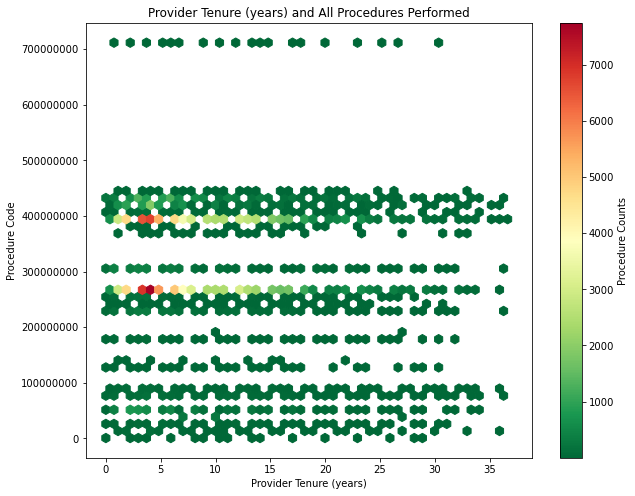

In [59]:
fig, axs = plt.subplots(figsize=(10, 8))
ax = axs
hb1 = ax.hexbin(    x = dfPP_pvt_yr_cat["TenureYears"], 
                    y = dfPP_pvt_yr_cat["Procedure_Performed_Code"], 
                    C = dfPP_pvt_yr_cat["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=50, 
                    cmap="RdYlGn_r"
                    #sharex=False)
               )
ax.set_title("Provider Tenure (years) and All Procedures Performed")
ax.set_xlabel("Provider Tenure (years)")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

In [60]:
dfPP_pvt_yr_cat.groupby(["Procedure_Performed_Code",
                        "Procedure_Performed_Description",
                        "ProcedureCatCode",
                         "ProcedureCategory"])[["Procedure_Count"]].sum().nlargest(2,["Procedure_Count"])

,,,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,ProcedureCatCode,ProcedureCategory,
268400002,CV - ECG - 12 Lead Obtained,11,CV - ECG,66972
392230005,IV Start - Extremity Vein (arm or leg),21,IV Start - Vein,59835


Compare the hexbin plots, where the second plot does not include the two highest count procedures.

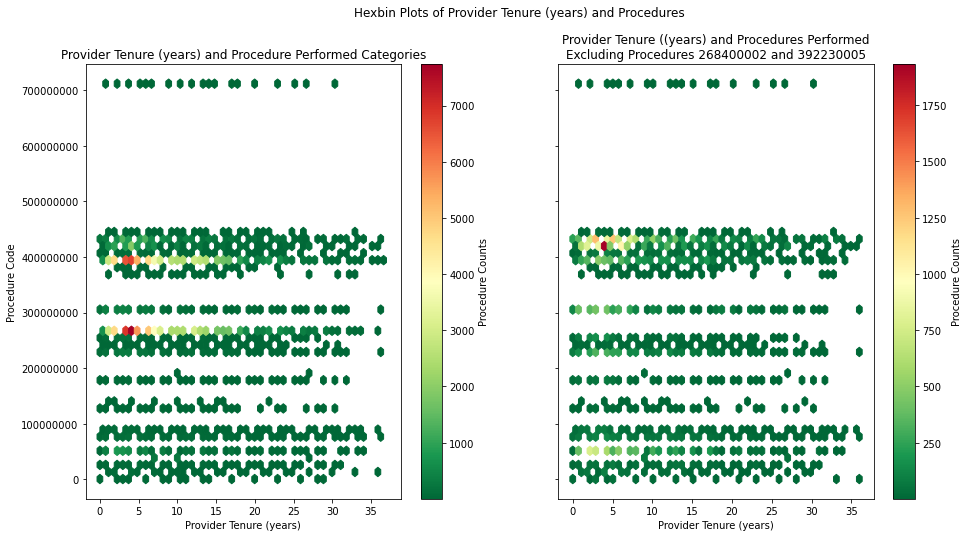

In [61]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(14, 8))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
fig.suptitle("Hexbin Plots of Provider Tenure (years) and Procedures")
ax = axs[0]
hb1 = ax.hexbin(    x = dfPP_pvt_yr_cat["TenureYears"], 
                    y = dfPP_pvt_yr_cat["Procedure_Performed_Code"], 
                    C = dfPP_pvt_yr_cat["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=50, 
                    cmap="RdYlGn_r", 
                    #xlabel="Provider Tenure", 
                    #ylabel="Procedure Code", 
                    #title="Provider Tenure and All Procedures Performed",
                    #sharex=False)
               )
#ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.set_title("Provider Tenure (years) and Procedure Performed Categories")
ax.set_xlabel("Provider Tenure (years)")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

ax = axs[1]
hb2 = ax.hexbin(    x = dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 392230005)]["TenureYears"],
                    y = dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 392230005)]["Procedure_Performed_Code"],
                    C = dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 392230005)]["Procedure_Count"],
                    reduce_C_function=np.sum,
                    gridsize=50,
                    cmap="RdYlGn_r",
                    #xlabel="Provider Tenure",
                    #ylabel="Procedure Code",
                    #title="Provider Tenure and Procedures Performed",
                    #sharex=False)
               )
#ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.set_title("Provider Tenure ((years) and Procedures Performed\nExcluding Procedures 268400002 and 392230005")
ax.set_xlabel("Provider Tenure (years)")
cb = fig.colorbar(hb2, ax=ax)
cb.set_label('Procedure Counts')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

Using the tenure in years, makes it much easier to see potential gaps in procedures occuring for certain tenures.  However, since the hexbin plot only shows the Procedure Codes, let's take a different look in a way that will allow the procedure title to be utilized.

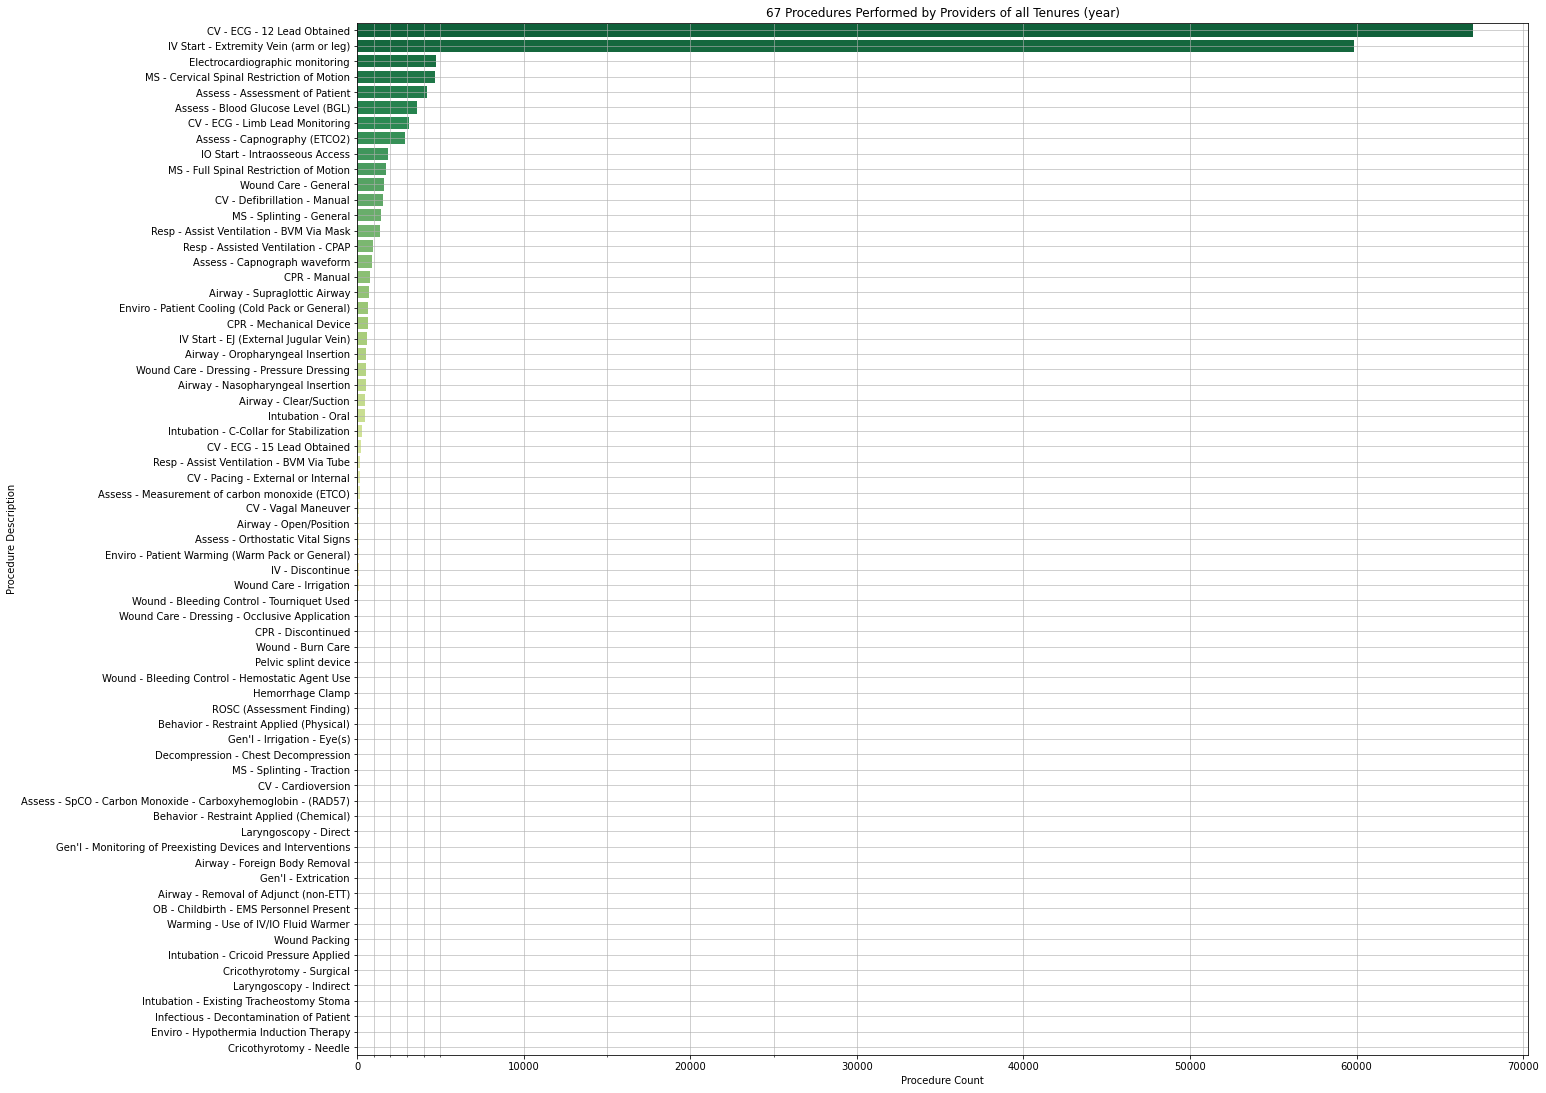

In [62]:
dfPP_pvt_yr_tot = BuildQntlTotDf(dfPP_pvt_yr,'Procedure_Performed_Code', 'Procedure_Performed_Description')
title = " ".join([str(proc_count_all),'Procedures Performed by Providers of all Tenures (year)'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0
tick_list = ticklst_30000 
x_range = xrng_30000  

fig, axs = plt.subplots(figsize=(17, 16))
#fig.suptitle("All Procedures by Tenure, ordered by total count")
fig.tight_layout()
fig.subplots_adjust(top=0.92)

# q1 tenure
sns.barplot(ax=axs, x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', #'pastel', 
                 order=ProcOrder,
                 data=dfPP_pvt_yr_tot)
axs.set_ylabel('Procedure Description')
axs.set_xlabel('Procedure Count')
axs.set_title(title)
axs.set_xticks(minor=True, ticks=tick_list)
axs.grid(axis='both', alpha=.75, which='both')

# show plots
plt.show()


Now going to take a look at how the procedure distribution looks when taking the pivot by tenure in years in quantile slices.

Create dataframes for each quantile < 0.25, between 0.25 and 0.5, between 0.5 and 0.75, and between 0.75 and 1 

In [63]:
# create the first quantile dataframe
dfPP_pvt_yr_q1 = BuildTenureQrtlDf(dfPP_pvt_yr_cat,0.0,0.25)
print(dfPP_pvt_yr_q1.shape)
dfPP_pvt_yr_q1.groupby(['TenureYears']).size().to_frame(name='Count')

(333, 6)


,Count
TenureYears,
0.0,43
1.0,54
2.0,56
3.0,58
4.0,63
5.0,59


In [64]:
# count the number of procedures included
q1_proc_count = dfPP_pvt_yr_q1['Procedure_Performed_Code'].nunique()
print(q1_proc_count)
# get year ranges
q1_low_yr = dfPP_pvt_yr_q1['TenureYears'].min()
print(q1_low_yr)
q1_high_yr = dfPP_pvt_yr_q1['TenureYears'].max()
print(q1_high_yr)

66
0.0
5.0


In [65]:
# create the second quantile dataframe
dfPP_pvt_yr_q2 = BuildTenureQrtlDf(dfPP_pvt_yr_cat,0.25,0.5)
print(dfPP_pvt_yr_q2.shape)
#dfPP_pvt_yr_q2.groupby(['TenureYears']).size().to_frame(name='Row Count')

(377, 6)


In [66]:
# count the number of procedures included
q2_proc_count = dfPP_pvt_yr_q2['Procedure_Performed_Code'].nunique()
print(q2_proc_count)
# get year ranges
q2_low_yr = dfPP_pvt_yr_q2['TenureYears'].min()
print(q2_low_yr)
q2_high_yr = dfPP_pvt_yr_q2['TenureYears'].max()
print(q2_high_yr)

64
6.0
12.0


In [67]:
# create the third quantile dataframe
dfPP_pvt_yr_q3 = BuildTenureQrtlDf(dfPP_pvt_yr_cat,0.5,0.75)
print(dfPP_pvt_yr_q3.shape)
#dfPP_pvt_yr_q3.groupby(['TenureYears']).size().to_frame(name='Count')

(382, 6)


In [68]:
# count the number of procedures included
q3_proc_count = dfPP_pvt_yr_q3['Procedure_Performed_Code'].nunique()
print(q3_proc_count)
# get year ranges
q3_low_yr = dfPP_pvt_yr_q3['TenureYears'].min()
print(q3_low_yr)
q3_high_yr = dfPP_pvt_yr_q3['TenureYears'].max()
print(q3_high_yr)

64
13.0
20.0


In [69]:
# create the fourth quantile dataframe
dfPP_pvt_yr_q4 = BuildTenureQrtlDf(dfPP_pvt_yr_cat,0.75,1.0)
print(dfPP_pvt_yr_q4.shape)
#dfPP_pvt_yr_q4.groupby(['TenureYears']).size().to_frame(name='Count')

(415, 6)


In [70]:
# count the number of procedures included
q4_proc_count = dfPP_pvt_yr_q4['Procedure_Performed_Code'].nunique()
print(q4_proc_count)
# get year ranges
q4_low_yr = dfPP_pvt_yr_q4['TenureYears'].min()
print(q4_low_yr)
q4_high_yr = dfPP_pvt_yr_q4['TenureYears'].max()
print(q4_high_yr)

56
21.0
36.0


In [71]:
# set up dataframes that only have the total sum of procedures using the quantile dataframes as starting points
dfPP_pvt_yr_q1tot = BuildQntlTotDf(dfPP_pvt_yr_q1,'Procedure_Performed_Code', 'Procedure_Performed_Description')
dfPP_pvt_yr_q2tot = BuildQntlTotDf(dfPP_pvt_yr_q2,'Procedure_Performed_Code', 'Procedure_Performed_Description')
dfPP_pvt_yr_q3tot = BuildQntlTotDf(dfPP_pvt_yr_q3,'Procedure_Performed_Code', 'Procedure_Performed_Description')
dfPP_pvt_yr_q4tot = BuildQntlTotDf(dfPP_pvt_yr_q4,'Procedure_Performed_Code', 'Procedure_Performed_Description')



Using these dataframes, build a side by side barchart to see if there are any indicators.

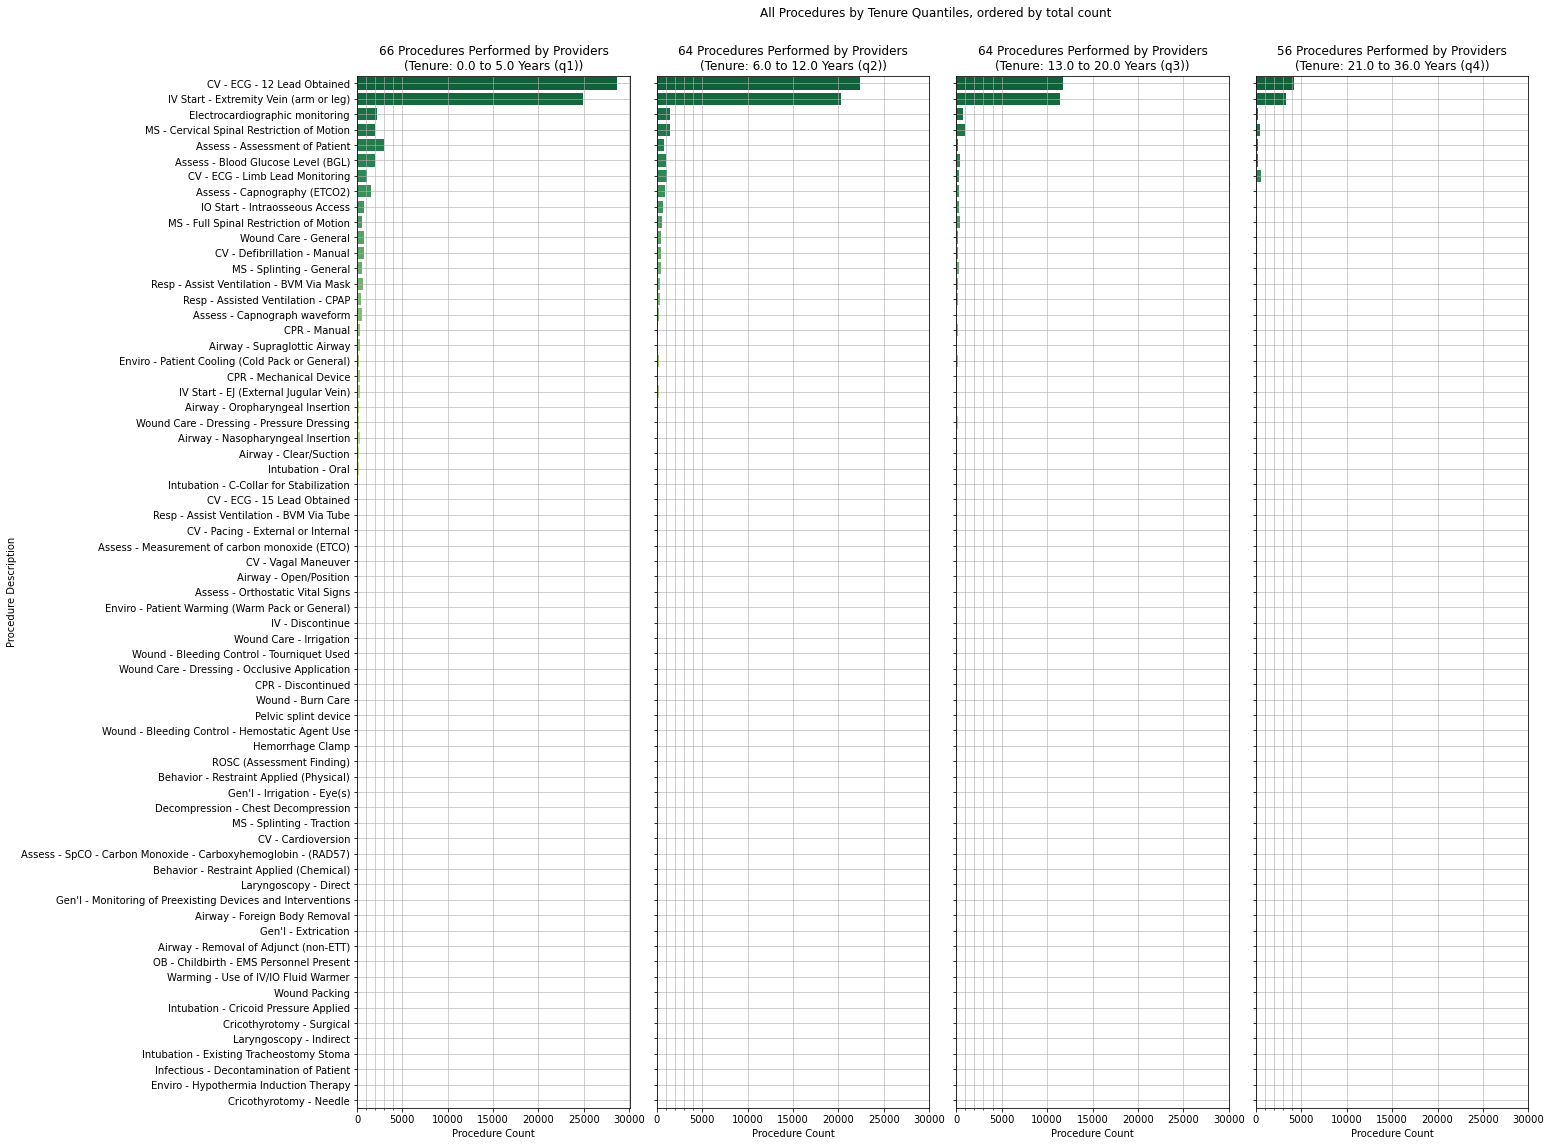

In [72]:
title_q4 = " ".join([str(q4_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0
tick_list = ticklst_30000 
x_range = xrng_30000  

fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(17, 16))
fig.suptitle("All Procedures by Tenure Quantiles, ordered by total count")
fig.tight_layout()
fig.subplots_adjust(top=0.92)

# q1 tenure
sns.barplot(ax=axs[0], x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', #'pastel', 
                 order=ProcOrder,
                 data=dfPP_pvt_yr_q1tot)
axs[0].set_ylabel('Procedure Description')
axs[0].set_xlabel('Procedure Count')
axs[0].set_title(title_q1)
axs[0].set_xticks(minor=True, ticks=tick_list)
axs[0].grid(axis='both', alpha=.75, which='both')

# q2 tenure
sns.barplot(ax=axs[1],x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', #'pastel', 
                 order=ProcOrder,
                 data=dfPP_pvt_yr_q2tot)
axs[1].set_ylabel('')
axs[1].set_xlabel('Procedure Count')
axs[1].set_title(title_q2)
axs[1].set_xticks(minor=True, ticks=tick_list)
axs[1].grid(axis='both', alpha=.75, which='both')
plt.xlim(x_range)

# q3 tenure
sns.barplot(ax=axs[2], x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', #'pastel', 
                 order=ProcOrder,
                 data=dfPP_pvt_yr_q3tot)
axs[2].set_ylabel('')
axs[2].set_xlabel('Procedure Count')
axs[2].set_title(title_q3)
axs[2].set_xticks(minor=True, ticks=tick_list)
axs[2].grid(axis='both', alpha=.75, which='both')
plt.xlim(x_range)

# q4 tenure
sns.barplot(ax=axs[3], x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', #'pastel', 
                 order=ProcOrder,
                 data=dfPP_pvt_yr_q4tot)
axs[3].set_ylabel('')
axs[3].set_xlabel('Procedure Count')
axs[3].set_title(title_q4)
axs[3].set_xticks(minor=True, ticks=tick_list)
axs[3].grid(axis='both', alpha=.75, which='both')
plt.xlim(x_range)

# show plots
plt.show()


In [73]:
# set up dataframes that DO NOT contain the top two procedures
dfPP_pvt_yr_q1tota = dfPP_pvt_yr_q1tot[(dfPP_pvt_yr_q1tot['Procedure_Performed_Code'] != 268400002) & 
                                     (dfPP_pvt_yr_q1tot['Procedure_Performed_Code'] != 392230005)]
dfPP_pvt_yr_q2tota = dfPP_pvt_yr_q2tot[(dfPP_pvt_yr_q2tot['Procedure_Performed_Code'] != 268400002) & 
                                     (dfPP_pvt_yr_q2tot['Procedure_Performed_Code'] != 392230005)]
dfPP_pvt_yr_q3tota = dfPP_pvt_yr_q3tot[(dfPP_pvt_yr_q3tot['Procedure_Performed_Code'] != 268400002) & 
                                     (dfPP_pvt_yr_q3tot['Procedure_Performed_Code'] != 392230005)]
dfPP_pvt_yr_q4tota = dfPP_pvt_yr_q4tot[(dfPP_pvt_yr_q4tot['Procedure_Performed_Code'] != 268400002) & 
                                     (dfPP_pvt_yr_q4tot['Procedure_Performed_Code'] != 392230005)]


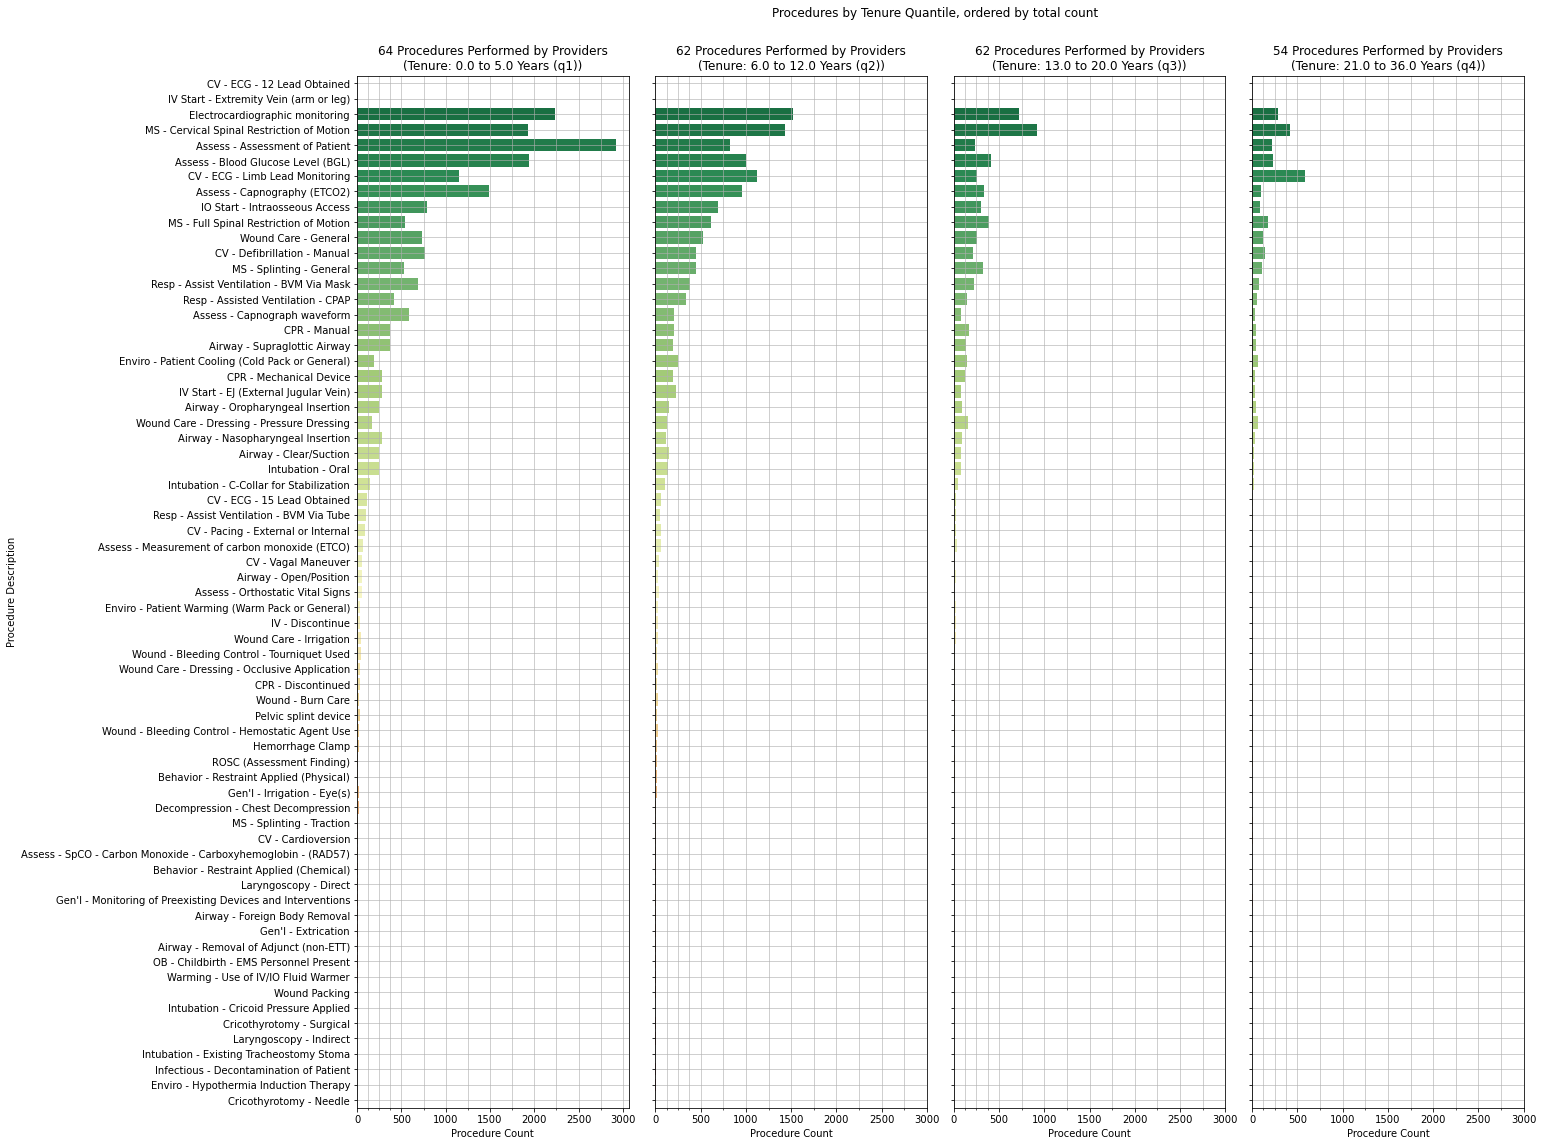

In [74]:
title_q4 = " ".join([str(q4_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0

tick_list = ticklst_3000
x_range = xrng_3000

fig, axs = plt.subplots(ncols=4, sharey='row', figsize=(17, 16))
plt.xlim(x_range)
fig.suptitle("Procedures by Tenure Quantile, ordered by total count")
fig.tight_layout()
fig.subplots_adjust(top=0.92)

# q1 tenure
sns.barplot(ax=axs[0], x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', 
                 order=ProcOrder,
                 data=dfPP_pvt_yr_q1tota)
axs[0].set_ylabel('Procedure Description')
axs[0].set_xlabel('Procedure Count')
axs[0].set_title(title_q1)
axs[0].set_xticks(minor=True, ticks=tick_list)
axs[0].grid(axis='both', alpha=.75, which='both')

# q2 tenure
sns.barplot(ax=axs[1],x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', 
                 order=ProcOrder,
                 data=dfPP_pvt_yr_q2tota)
axs[1].set_ylabel('')
axs[1].set_xlabel('Procedure Count')
axs[1].set_title(title_q2)
axs[1].set_xticks(minor=True, ticks=tick_list)
axs[1].grid(axis='both', alpha=.75, which='both')
plt.setp(axs[2].get_yticklabels(), visible=False)

# q3 tenure
sns.barplot(ax=axs[2], x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', 
                 order=ProcOrder,
                 data=dfPP_pvt_yr_q3tota)
axs[2].set_ylabel('')
axs[2].set_xlabel('Procedure Count')
axs[2].set_title(title_q3)
axs[2].set_xticks(minor=True, ticks=tick_list)
axs[2].grid(axis='both', alpha=.75, which='both')
plt.setp(axs[2].get_yticklabels(), visible=False)


# q4 tenure
sns.barplot(ax=axs[3], x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', 
                 order=ProcOrder,
                 data=dfPP_pvt_yr_q4tota)
axs[3].set_ylabel('')
axs[3].set_xlabel('Procedure Count')
axs[3].set_title(title_q4)
axs[3].set_xticks(minor=True, ticks=tick_list)
axs[3].grid(axis='both', alpha=.75, which='both')

# show the plots
plt.show()



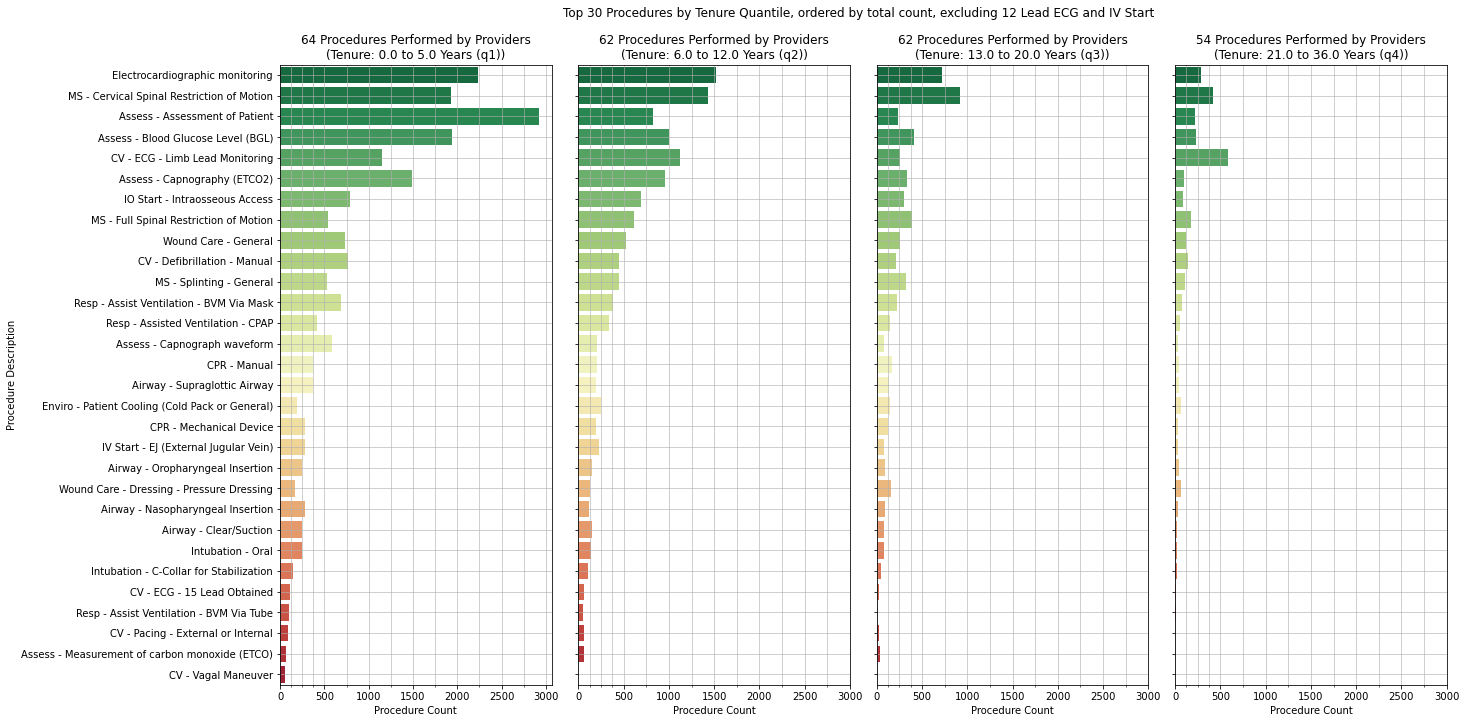

In [75]:
# build plots that exclude the top two highest procedure counts and only show the next 25 highest
title_q4 = " ".join([str(q4_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0

tick_list = ticklst_3000
x_range = xrng_3000

fig, axs = plt.subplots(ncols=4, sharey='row', figsize=(17, 10))
plt.xlim(x_range)
fig.suptitle("Top 30 Procedures by Tenure Quantile, ordered by total count, excluding 12 Lead ECG and IV Start")
fig.tight_layout()
fig.subplots_adjust(top=0.90)

# q1 tenure
sns.barplot(ax=axs[0], x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', 
                 order=ProcOrder[2:32],
                 data=dfPP_pvt_yr_q1tota.nlargest(30,["Procedure_Count"]))
axs[0].set_ylabel('Procedure Description')
axs[0].set_xlabel('Procedure Count')
axs[0].set_title(title_q1)
axs[0].set_xticks(minor=True, ticks=tick_list)
axs[0].grid(axis='both', alpha=.75, which='both')

# q2 tenure
sns.barplot(ax=axs[1],x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', 
                 order=ProcOrder[2:32],
                 data=dfPP_pvt_yr_q2tota.nlargest(30,["Procedure_Count"]))
axs[1].set_ylabel('')
axs[1].set_xlabel('Procedure Count')
axs[1].set_title(title_q2)
axs[1].set_xticks(minor=True, ticks=tick_list)
axs[1].grid(axis='both', alpha=.75, which='both')
plt.setp(axs[2].get_yticklabels(), visible=False)

# q3 tenure
sns.barplot(ax=axs[2], x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', 
                 order=ProcOrder[2:32],
                 data=dfPP_pvt_yr_q3tota.nlargest(30,["Procedure_Count"]))
axs[2].set_ylabel('')
axs[2].set_xlabel('Procedure Count')
axs[2].set_title(title_q3)
axs[2].set_xticks(minor=True, ticks=tick_list)
axs[2].grid(axis='both', alpha=.75, which='both')
plt.setp(axs[2].get_yticklabels(), visible=False)


# q4 tenure
sns.barplot(ax=axs[3], x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', 
                 order=ProcOrder[2:32],
                 data=dfPP_pvt_yr_q4tota.nlargest(30,["Procedure_Count"]))
axs[3].set_ylabel('')
axs[3].set_xlabel('Procedure Count')
axs[3].set_title(title_q4)
axs[3].set_xticks(minor=True, ticks=tick_list)
axs[3].grid(axis='both', alpha=.75, which='both')

# show the plots
plt.show()



Using this plot, there are two items that are now visible.  

1. For the procedure "Assess - Assessment of Patient", the count displayed in the first quantile chart is the highest of all other procedures in that chart.  In fact, in the other 3 quantile charts this procedure's count is lower than at least 5 other procedures

2. For he procedure "CV - ECG - Limb Lead Monitoring", the count displayed in the fourth quantile chart is the highest of all other procedures in that chart.  This procedure in the other charts, while having one of the higher counts, is nowhere near the highest.

Use the procedure categories to see if anything new can be seen

First going to take a look at how the procedure distribution looks when taking the pivot by tenure in years in quantile slices.

Regenerate the plots for the four quantiles, but this time use the full listing of procedure categories.

In [76]:
# build category based quantile total dataframes
dfPP_pvt_yr_q1totcat = BuildQntlTotDf(dfPP_pvt_yr_q1,'ProcedureCatCode', 'ProcedureCategory')
dfPP_pvt_yr_q2totcat = BuildQntlTotDf(dfPP_pvt_yr_q2,'ProcedureCatCode', 'ProcedureCategory')
dfPP_pvt_yr_q3totcat = BuildQntlTotDf(dfPP_pvt_yr_q3,'ProcedureCatCode', 'ProcedureCategory')
dfPP_pvt_yr_q4totcat = BuildQntlTotDf(dfPP_pvt_yr_q4,'ProcedureCatCode', 'ProcedureCategory')

# count the number of procedures included
q1_cat_count = dfPP_pvt_yr_q1['ProcedureCatCode'].nunique()
q2_cat_count = dfPP_pvt_yr_q2['ProcedureCatCode'].nunique()
q3_cat_count = dfPP_pvt_yr_q3['ProcedureCatCode'].nunique()
q4_cat_count = dfPP_pvt_yr_q4['ProcedureCatCode'].nunique()

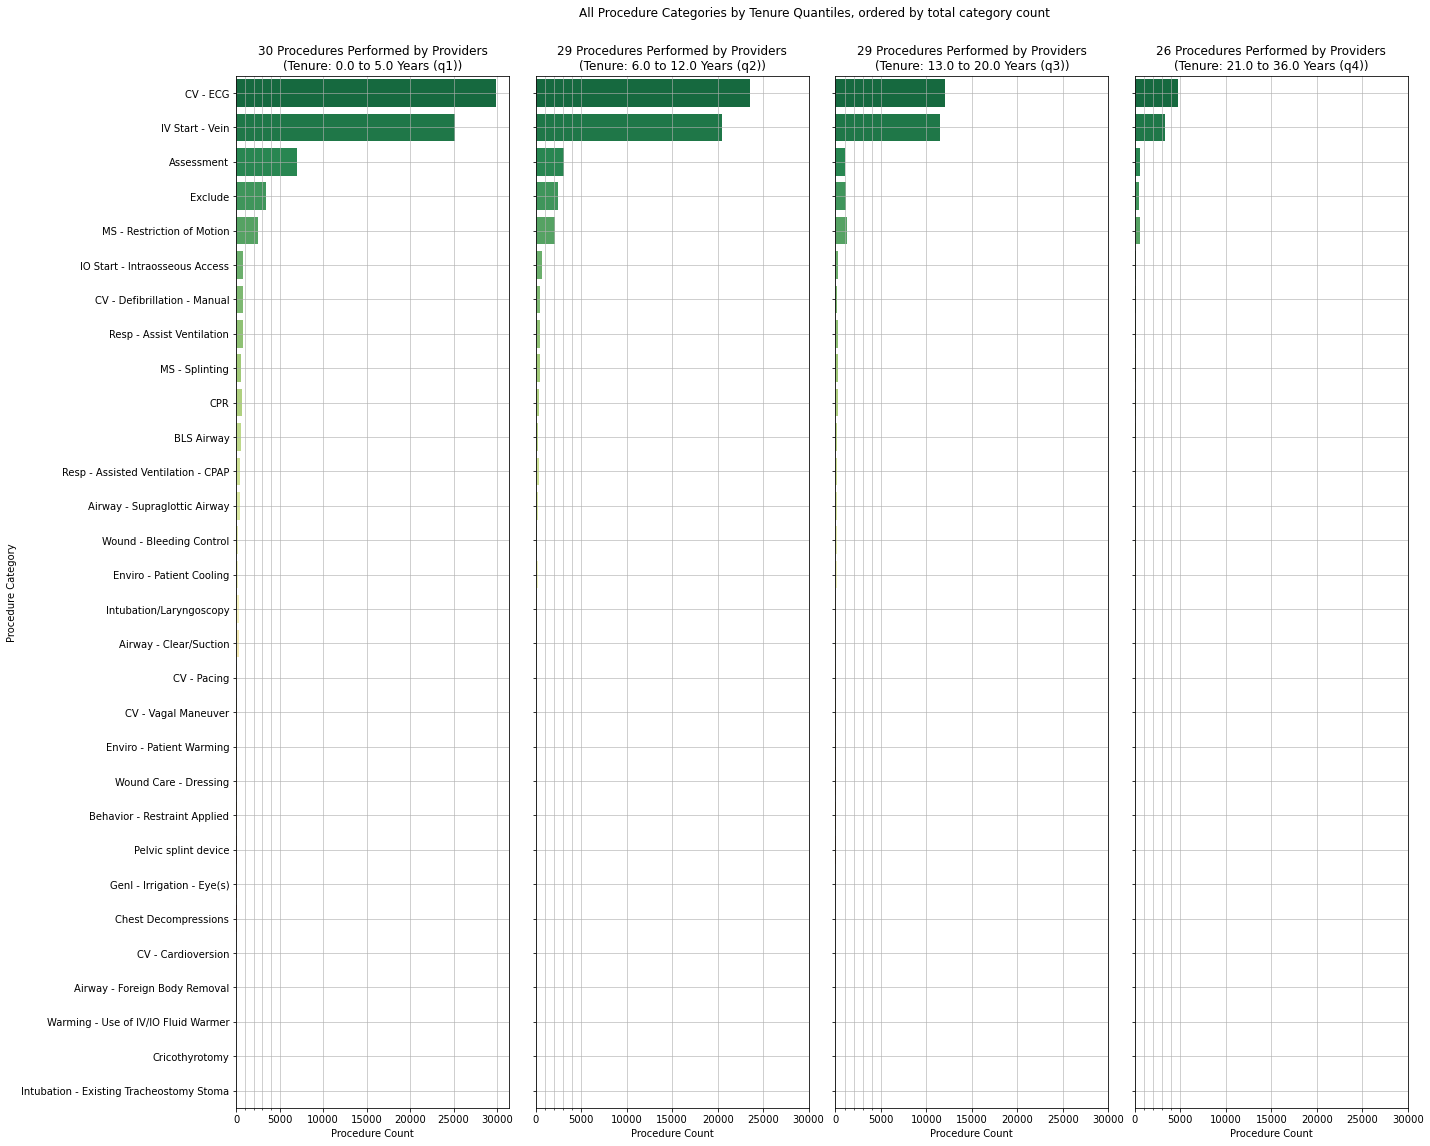

In [77]:
title_q4 = " ".join([str(q4_cat_count),'Procedures Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_cat_count),'Procedures Performed by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_cat_count),'Procedures Performed by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_cat_count),'Procedures Performed by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0
tick_list = ticklst_30000 
x_range = xrng_30000  

fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(17, 16))
fig.suptitle("All Procedure Categories by Tenure Quantiles, ordered by total category count")
fig.tight_layout()
fig.subplots_adjust(top=0.92)

# q1 tenure
sns.barplot(ax=axs[0], x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', #'pastel', 
                 order=ProcCatOrder,
                 data=dfPP_pvt_yr_q1totcat)
axs[0].set_ylabel('Procedure Category')
axs[0].set_xlabel('Procedure Count')
axs[0].set_title(title_q1)
axs[0].set_xticks(minor=True, ticks=tick_list)
axs[0].grid(axis='both', alpha=.75, which='both')

# q2 tenure
sns.barplot(ax=axs[1],x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', #'pastel', 
                 order=ProcCatOrder,
                 data=dfPP_pvt_yr_q2totcat)
axs[1].set_ylabel('')
axs[1].set_xlabel('Procedure Count')
axs[1].set_title(title_q2)
axs[1].set_xticks(minor=True, ticks=tick_list)
axs[1].grid(axis='both', alpha=.75, which='both')
plt.xlim(x_range)

# q3 tenure
sns.barplot(ax=axs[2], x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', #'pastel', 
                 order=ProcCatOrder,
                 data=dfPP_pvt_yr_q3totcat)
axs[2].set_ylabel('')
axs[2].set_xlabel('Procedure Count')
axs[2].set_title(title_q3)
axs[2].set_xticks(minor=True, ticks=tick_list)
axs[2].grid(axis='both', alpha=.75, which='both')
plt.xlim(x_range)

# q4 tenure
sns.barplot(ax=axs[3], x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', #'pastel', 
                 order=ProcCatOrder,
                 data=dfPP_pvt_yr_q4totcat)
axs[3].set_ylabel('')
axs[3].set_xlabel('Procedure Count')
axs[3].set_title(title_q4)
axs[3].set_xticks(minor=True, ticks=tick_list)
axs[3].grid(axis='both', alpha=.75, which='both')
plt.xlim(x_range)

# show plots
plt.show()


In [78]:
# set up dataframes that DO NOT contain the top two procedures
dfPP_pvt_yr_q1totcata = dfPP_pvt_yr_q1totcat[(dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 11) & 
                                     (dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 21)]
dfPP_pvt_yr_q2totcata = dfPP_pvt_yr_q2totcat[(dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 11) & 
                                     (dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 21)]
dfPP_pvt_yr_q3totcata = dfPP_pvt_yr_q3totcat[(dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 11) & 
                                     (dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 21)]
dfPP_pvt_yr_q4totcata = dfPP_pvt_yr_q4totcat[(dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 11) & 
                                     (dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 21)]


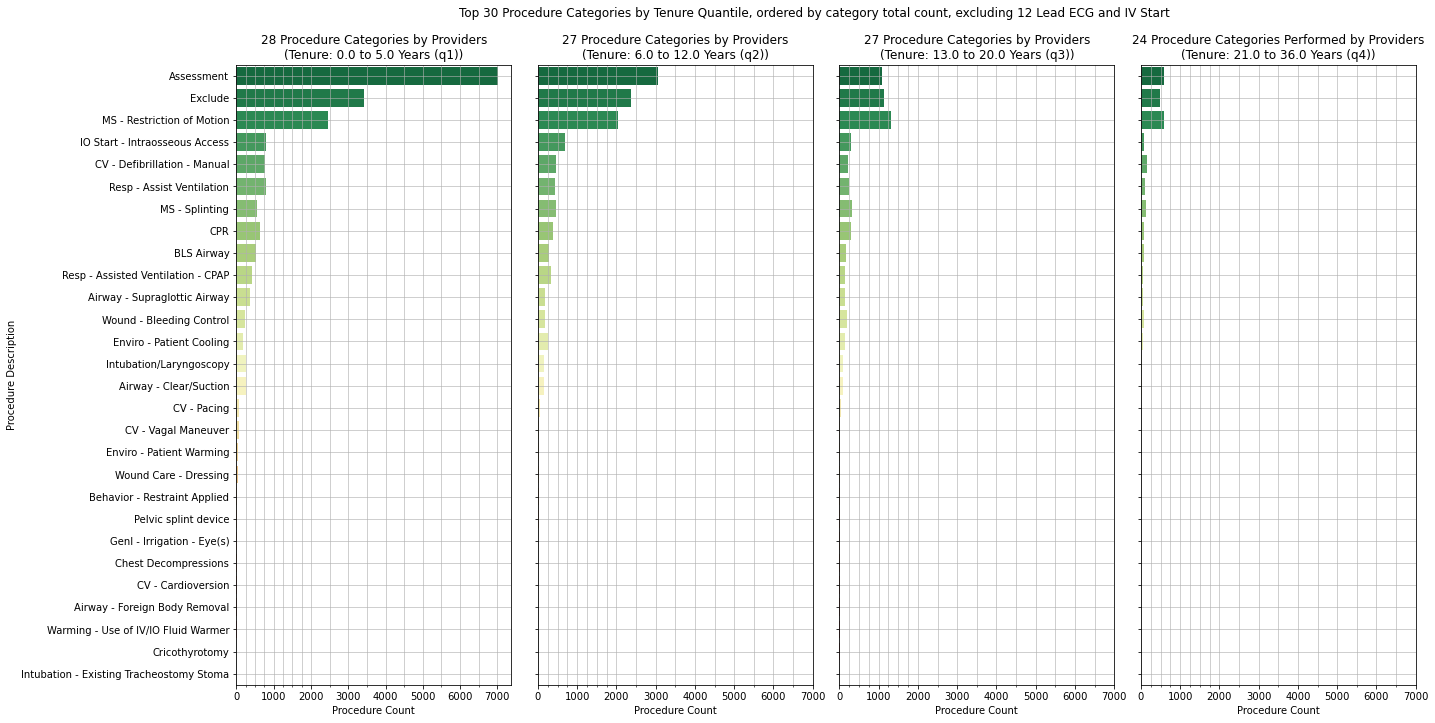

In [79]:
# build plots that exclude the top two highest procedure counts and only show the next 25 highest
title_q4 = " ".join([str(q4_cat_count-2),'Procedure Categories Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_cat_count-2),'Procedure Categories by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_cat_count-2),'Procedure Categories by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_cat_count-2),'Procedure Categories by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0

tick_list = ticklst_7000
x_range = xrng_7000

fig, axs = plt.subplots(ncols=4, sharey='row', figsize=(17, 10))
plt.xlim(x_range)
fig.suptitle("Top 30 Procedure Categories by Tenure Quantile, ordered by category total count, excluding 12 Lead ECG and IV Start")
fig.tight_layout()
fig.subplots_adjust(top=0.90)

# q1 tenure
sns.barplot(ax=axs[0], x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', 
                 order=ProcCatOrder[2:32],
                 data=dfPP_pvt_yr_q1totcata.nlargest(30,["Procedure_Count"]))
axs[0].set_ylabel('Procedure Description')
axs[0].set_xlabel('Procedure Count')
axs[0].set_title(title_q1)
axs[0].set_xticks(minor=True, ticks=tick_list)
axs[0].grid(axis='both', alpha=.75, which='both')

# q2 tenure
sns.barplot(ax=axs[1],x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', 
                 order=ProcCatOrder[2:32],
                 data=dfPP_pvt_yr_q2totcata.nlargest(30,["Procedure_Count"]))
axs[1].set_ylabel('')
axs[1].set_xlabel('Procedure Count')
axs[1].set_title(title_q2)
axs[1].set_xticks(minor=True, ticks=tick_list)
axs[1].grid(axis='both', alpha=.75, which='both')
plt.setp(axs[2].get_yticklabels(), visible=False)

# q3 tenure
sns.barplot(ax=axs[2], x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', 
                 order=ProcCatOrder[2:32],
                 data=dfPP_pvt_yr_q3totcata.nlargest(30,["Procedure_Count"]))
axs[2].set_ylabel('')
axs[2].set_xlabel('Procedure Count')
axs[2].set_title(title_q3)
axs[2].set_xticks(minor=True, ticks=tick_list)
axs[2].grid(axis='both', alpha=.75, which='both')
plt.setp(axs[2].get_yticklabels(), visible=False)


# q4 tenure
sns.barplot(ax=axs[3], x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', 
                 order=ProcCatOrder[2:32],
                 data=dfPP_pvt_yr_q4totcata.nlargest(30,["Procedure_Count"]))
axs[3].set_ylabel('')
axs[3].set_xlabel('Procedure Count')
axs[3].set_title(title_q4)
axs[3].set_xticks(minor=True, ticks=tick_list)
axs[3].grid(axis='both', alpha=.75, which='both')

# show the plots
plt.show()



What is included in the "Assesment" category?

In [80]:
dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'Assessment')].Procedure_Performed_Description.unique()


array(['Assess - Capnograph waveform',
       'Assess - Blood Glucose Level (BGL)',
       'Assess - Assessment of Patient', 'Assess - Capnography (ETCO2)',
       'Assess - Measurement of carbon monoxide (ETCO)',
       'Assess - SpCO - Carbon Monoxide - Carboxyhemoglobin - (RAD57)'],
      dtype=object)

In [81]:
dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'Assessment')].Procedure_Count.sum()

11758

What is included in the "Exclude" category?

In [82]:
dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'Exclude')].Procedure_Performed_Description.unique()
#dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat["ProcedureCategory"] == 'Exclude')]

array(['Electrocardiographic monitoring',
       'Intubation - C-Collar for Stabilization',
       "Gen'l - Monitoring of Preexisting Devices and Interventions",
       'Wound Care - Irrigation', 'Wound Care - General',
       'Airway - Open/Position', 'Airway - Removal of Adjunct (non-ETT)',
       'Hemorrhage Clamp', 'IV - Discontinue',
       'Assess - Orthostatic Vital Signs', "Gen'l - Extrication",
       'Wound - Burn Care', 'Intubation - Cricoid Pressure Applied',
       'CPR - Discontinued', 'ROSC (Assessment Finding)',
       'OB - Childbirth - EMS Personnel Present',
       'Infectious - Decontamination of Patient',
       'Enviro - Hypothermia Induction Therapy'], dtype=object)

In [83]:
dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'Exclude')].Procedure_Count.sum()

7440

In [84]:
# set up dataframes that DO NOT contain the top two procedures
dfPP_pvt_yr_q1totcatb = dfPP_pvt_yr_q1totcat[(dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 11) & 
                                             (dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 0)  &
                                             (dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 5)  &
                                             (dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 21)]
dfPP_pvt_yr_q2totcatb = dfPP_pvt_yr_q2totcat[(dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 11) & 
                                             (dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 0)  &
                                             (dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 5)  &
                                             (dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 21)]
dfPP_pvt_yr_q3totcatb = dfPP_pvt_yr_q3totcat[(dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 11) & 
                                             (dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 0)  &
                                             (dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 5)  &
                                             (dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 21)]
dfPP_pvt_yr_q4totcatb = dfPP_pvt_yr_q4totcat[(dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 11) & 
                                             (dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 0)  &
                                             (dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 5)  &
                                             (dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 21)]

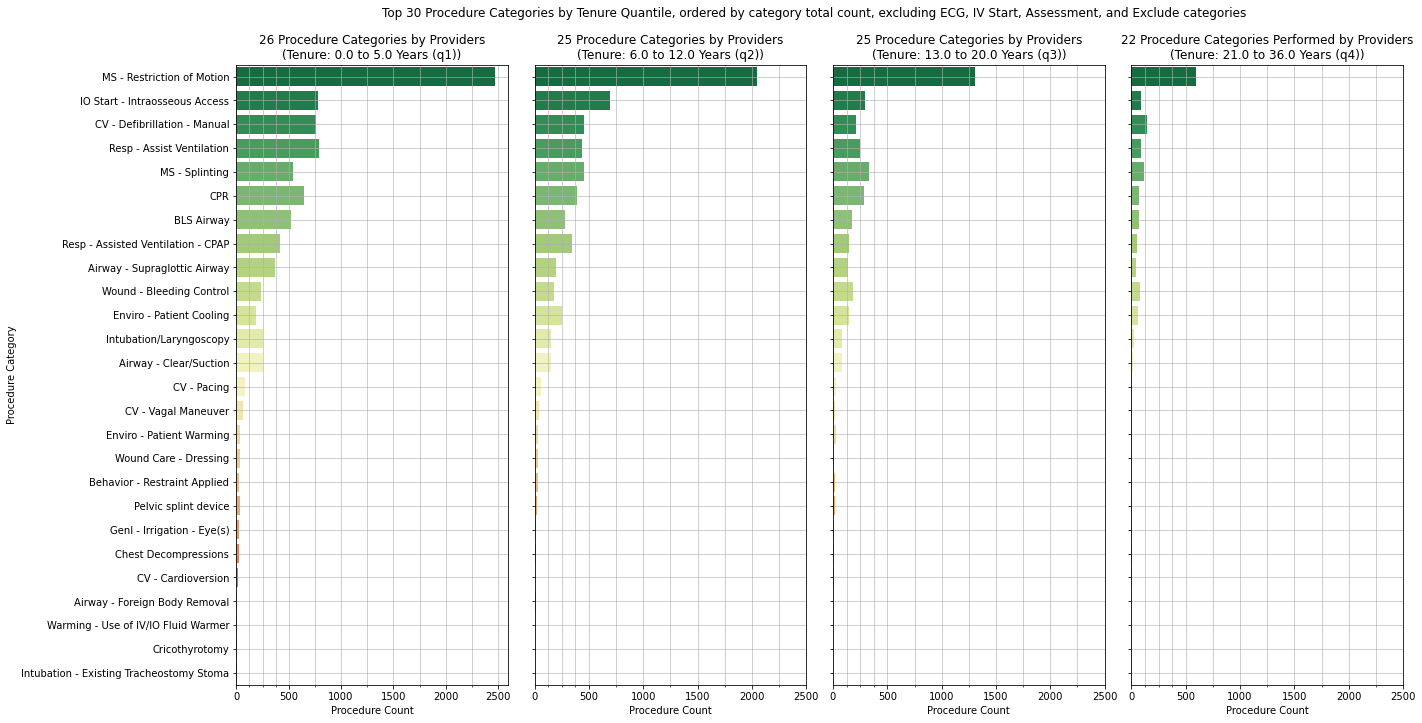

In [85]:
# build plots that exclude the top two highest procedure counts and only show the next 25 highest
title_q4 = " ".join([str(q4_cat_count-4),'Procedure Categories Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_cat_count-4),'Procedure Categories by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_cat_count-4),'Procedure Categories by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_cat_count-4),'Procedure Categories by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0

tick_list = ticklst_2500
x_range = xrng_2500

fig, axs = plt.subplots(ncols=4, sharey='row', figsize=(17, 10))
plt.xlim(x_range)
fig.suptitle("Top 30 Procedure Categories by Tenure Quantile, ordered by category total count, excluding ECG, IV Start, Assessment, and Exclude categories")
fig.tight_layout()
fig.subplots_adjust(top=0.90)

# q1 tenure
sns.barplot(ax=axs[0], x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', 
                 order=ProcCatOrder[4:32],
                 data=dfPP_pvt_yr_q1totcatb)
axs[0].set_ylabel('Procedure Category')
axs[0].set_xlabel('Procedure Count')
axs[0].set_title(title_q1)
axs[0].set_xticks(minor=True, ticks=tick_list)
axs[0].grid(axis='both', alpha=.75, which='both')

# q2 tenure
sns.barplot(ax=axs[1],x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', 
                 order=ProcCatOrder[4:32],
                 data=dfPP_pvt_yr_q2totcatb)
axs[1].set_ylabel('')
axs[1].set_xlabel('Procedure Count')
axs[1].set_title(title_q2)
axs[1].set_xticks(minor=True, ticks=tick_list)
axs[1].grid(axis='both', alpha=.75, which='both')
plt.setp(axs[2].get_yticklabels(), visible=False)

# q3 tenure
sns.barplot(ax=axs[2], x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', 
                 order=ProcCatOrder[4:32],
                 data=dfPP_pvt_yr_q3totcatb)
axs[2].set_ylabel('')
axs[2].set_xlabel('Procedure Count')
axs[2].set_title(title_q3)
axs[2].set_xticks(minor=True, ticks=tick_list)
axs[2].grid(axis='both', alpha=.75, which='both')
plt.setp(axs[2].get_yticklabels(), visible=False)


# q4 tenure
sns.barplot(ax=axs[3], x='Procedure_Count', 
                 y='ProcedureCategory', 
                 palette='RdYlGn_r', 
                 order=ProcCatOrder[4:32],
                 data=dfPP_pvt_yr_q4totcatb)
axs[3].set_ylabel('')
axs[3].set_xlabel('Procedure Count')
axs[3].set_title(title_q4)
axs[3].set_xticks(minor=True, ticks=tick_list)
axs[3].grid(axis='both', alpha=.75, which='both')

# show the plots
plt.show()



Now, let's take a look at the Procedure Categories plotted in a violin plot using area to normalize the values.

Text(0.5, 141.0, 'Tenure (years)')

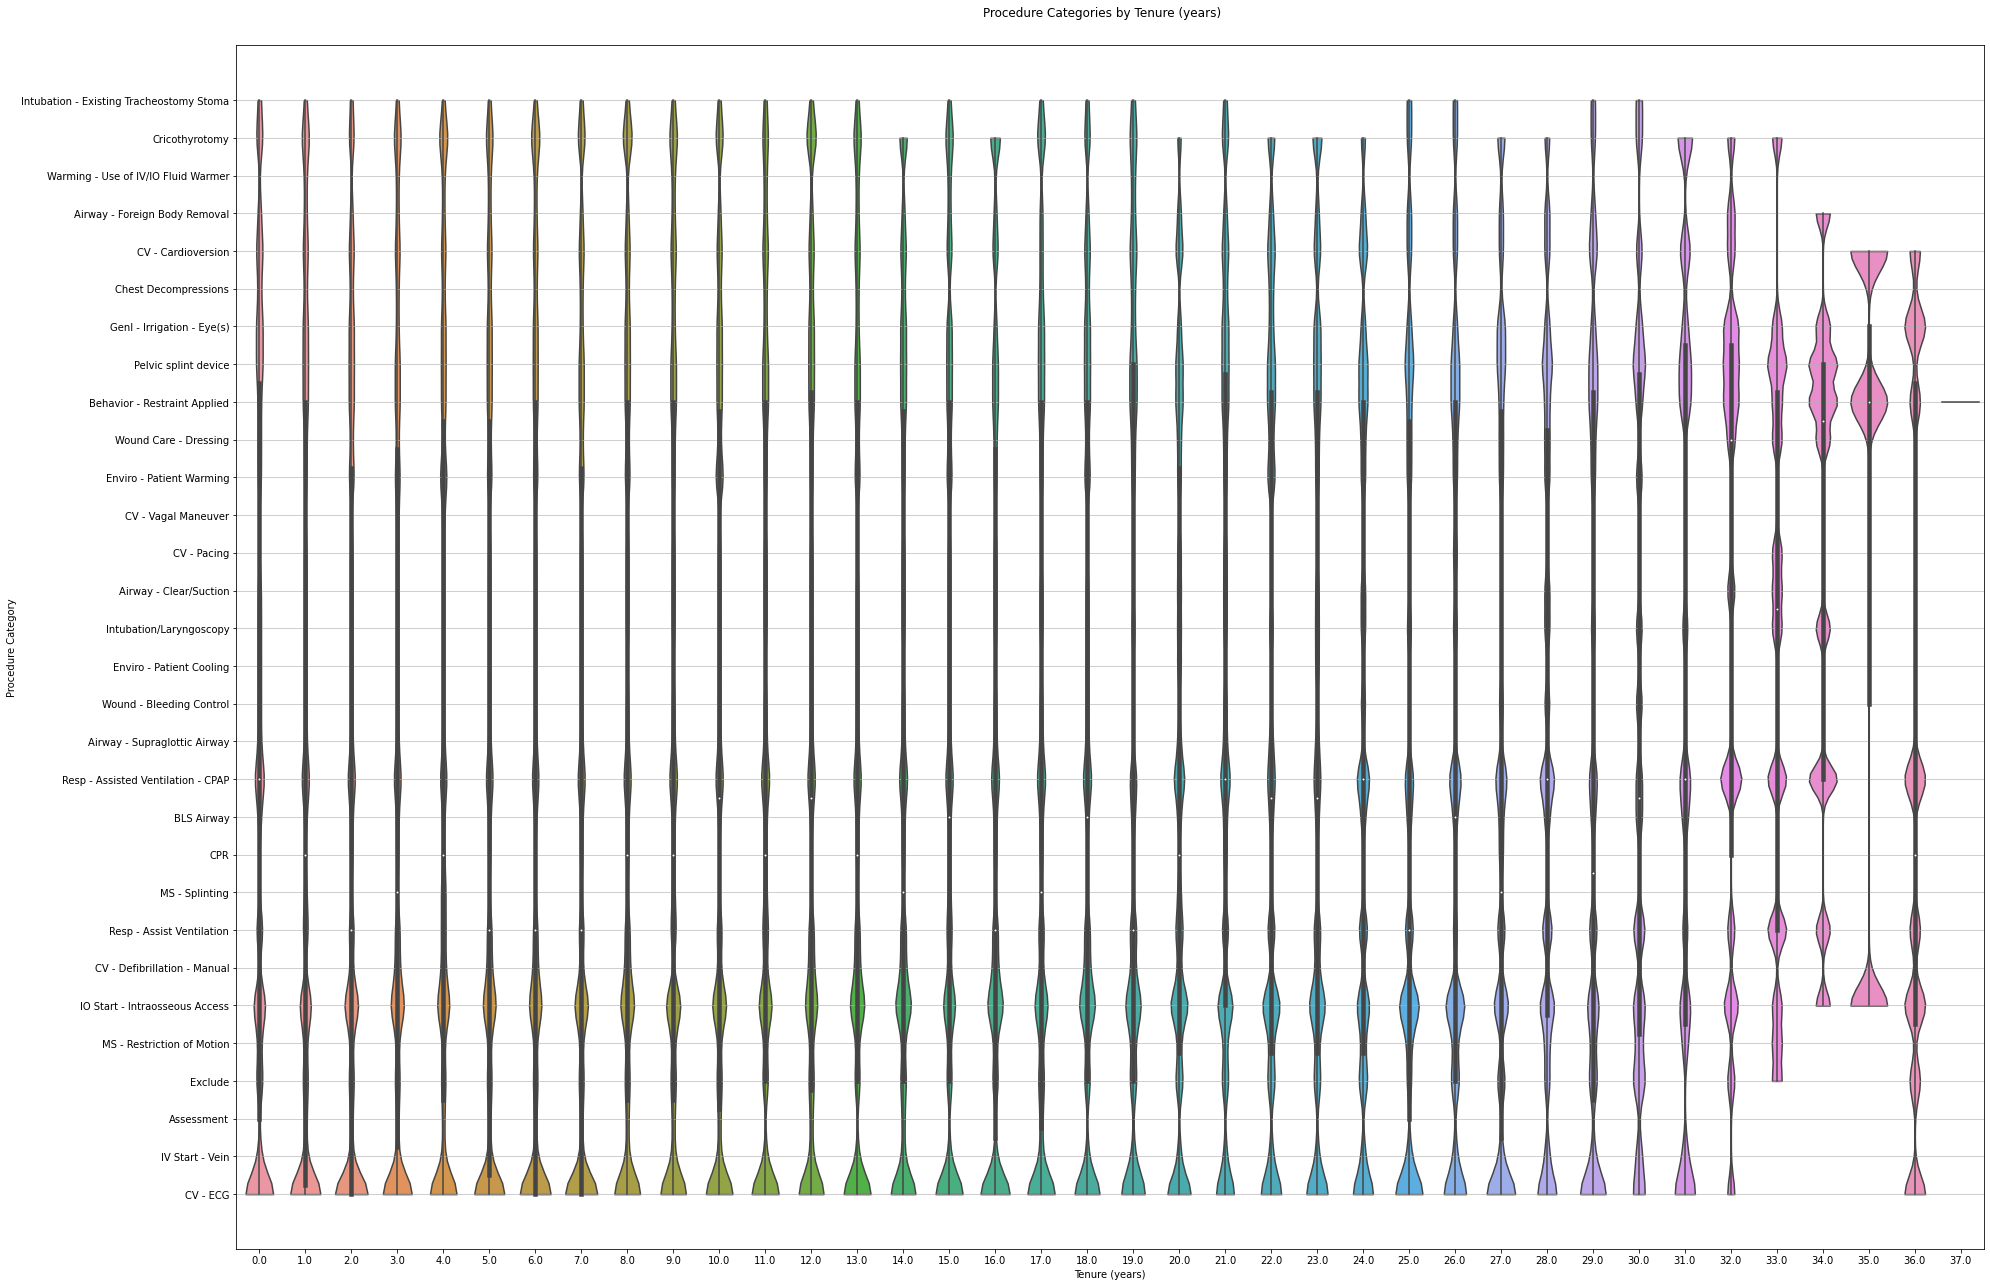

In [86]:
fig, axs = plt.subplots(figsize=(25,18))
fig.suptitle("Procedure Categories by Tenure (years)")
fig.tight_layout()
fig.subplots_adjust(top=0.95)

sns.violinplot(ax=axs, y="ProcedureCatCode",x="TenureYears",
               data=dfPP_pvt_yr_cat, 
               scale='area',
#              order=OutcomeOrder,
               bw=.05,
              cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList.index)
axs.set_yticklabels(dfProcCatList.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category")
axs.set_xlabel("Tenure (years)")


In [87]:
dfPP_pvt_yr_cat_dropexcl = dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCatCode'] != 0)]
print("Drop Exclude Category")
print(dfPP_pvt_yr_cat_dropexcl[(dfPP_pvt_yr_cat_dropexcl['ProcedureCategory'] == 'Exclude')].Procedure_Count.sum())
print(dfPP_pvt_yr_cat_dropexcl[(dfPP_pvt_yr_cat_dropexcl['ProcedureCatCode'] == 11)].Procedure_Count.sum())

dfPP_pvt_yr_cat_dropexcl_assess = dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCatCode'] != 0) & 
                                                  (dfPP_pvt_yr_cat['ProcedureCatCode'] != 5)]
print("Drop Assessment Category")
print(dfPP_pvt_yr_cat_dropexcl_assess[(dfPP_pvt_yr_cat_dropexcl_assess['ProcedureCategory'] == 'Assessment')].Procedure_Count.sum())
print(dfPP_pvt_yr_cat_dropexcl_assess[(dfPP_pvt_yr_cat_dropexcl_assess['ProcedureCatCode'] == 11)].Procedure_Count.sum())


Drop Exclude Category
0
70300
Drop Assessment Category
0
70300


In [88]:
#dfPP_pvt_yr_cat_dropexcl_assess

In [89]:
dfProcCatList_dropexcl = dfProcCatList[(dfProcCatList['ProcedureCatCode'] != 0)]
dfProcCatList_dropexcl_assess = dfProcCatList[(dfProcCatList['ProcedureCatCode'] != 0) & (dfProcCatList['ProcedureCatCode'] != 5)]

Text(198.0, 0.5, 'Procedure Category')

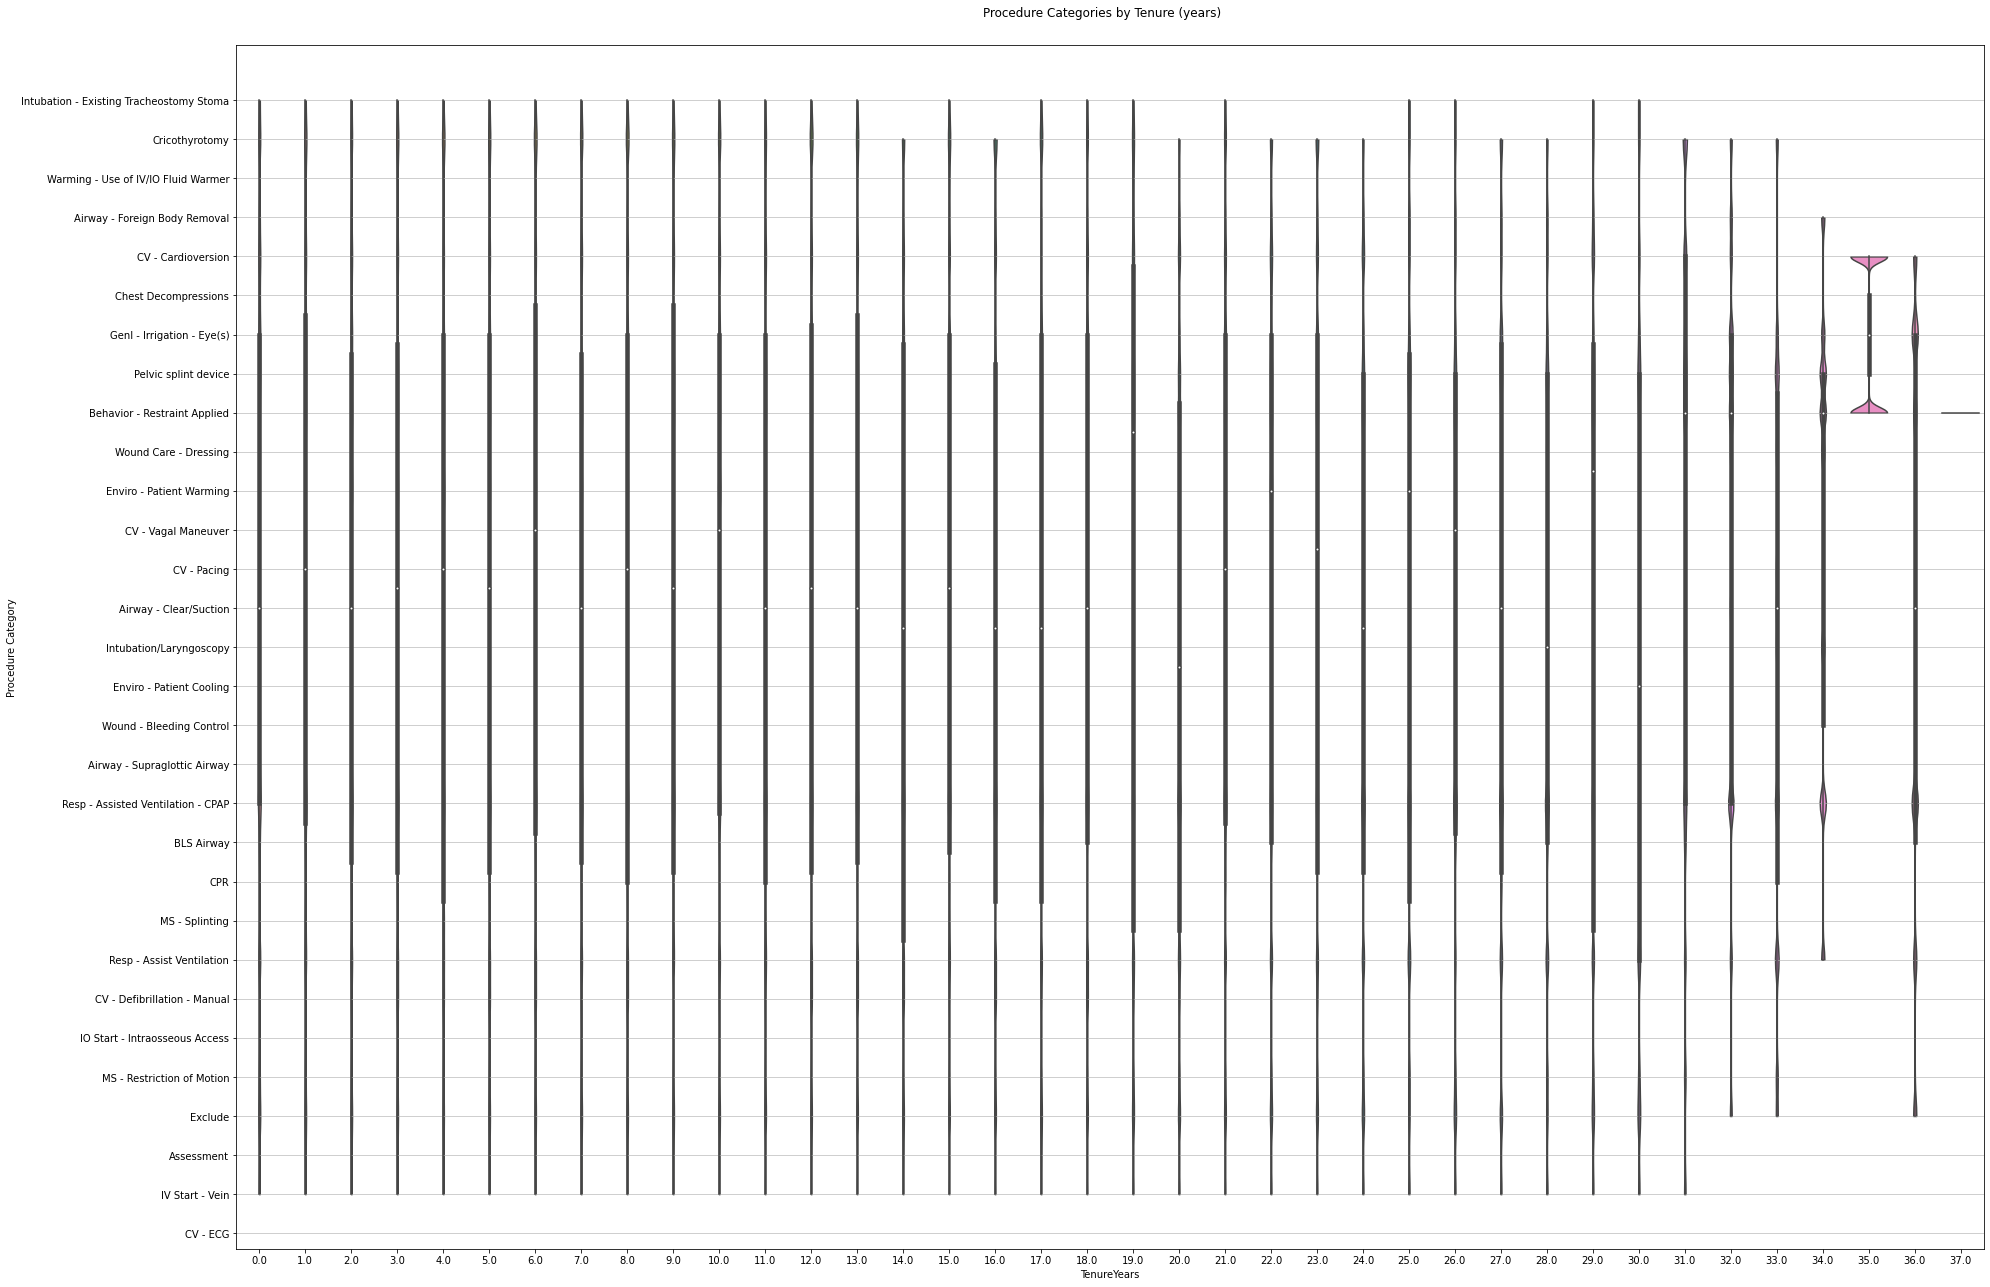

In [90]:
fig, axs = plt.subplots(figsize=(25,18))
fig.suptitle("Procedure Categories by Tenure (years)")
fig.tight_layout()
fig.subplots_adjust(top=0.95)

sns.violinplot(ax = axs, y="ProcedureCatCode",x="TenureYears",
               data=dfPP_pvt_yr_cat_dropexcl_assess, 
               scale='area',
#              order=OutcomeOrder,
               bw=.05,
              cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList_dropexcl_assess.index)
axs.set_yticklabels(dfProcCatList_dropexcl_assess.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category")


Text(0, 0.5, 'Procedure Category')

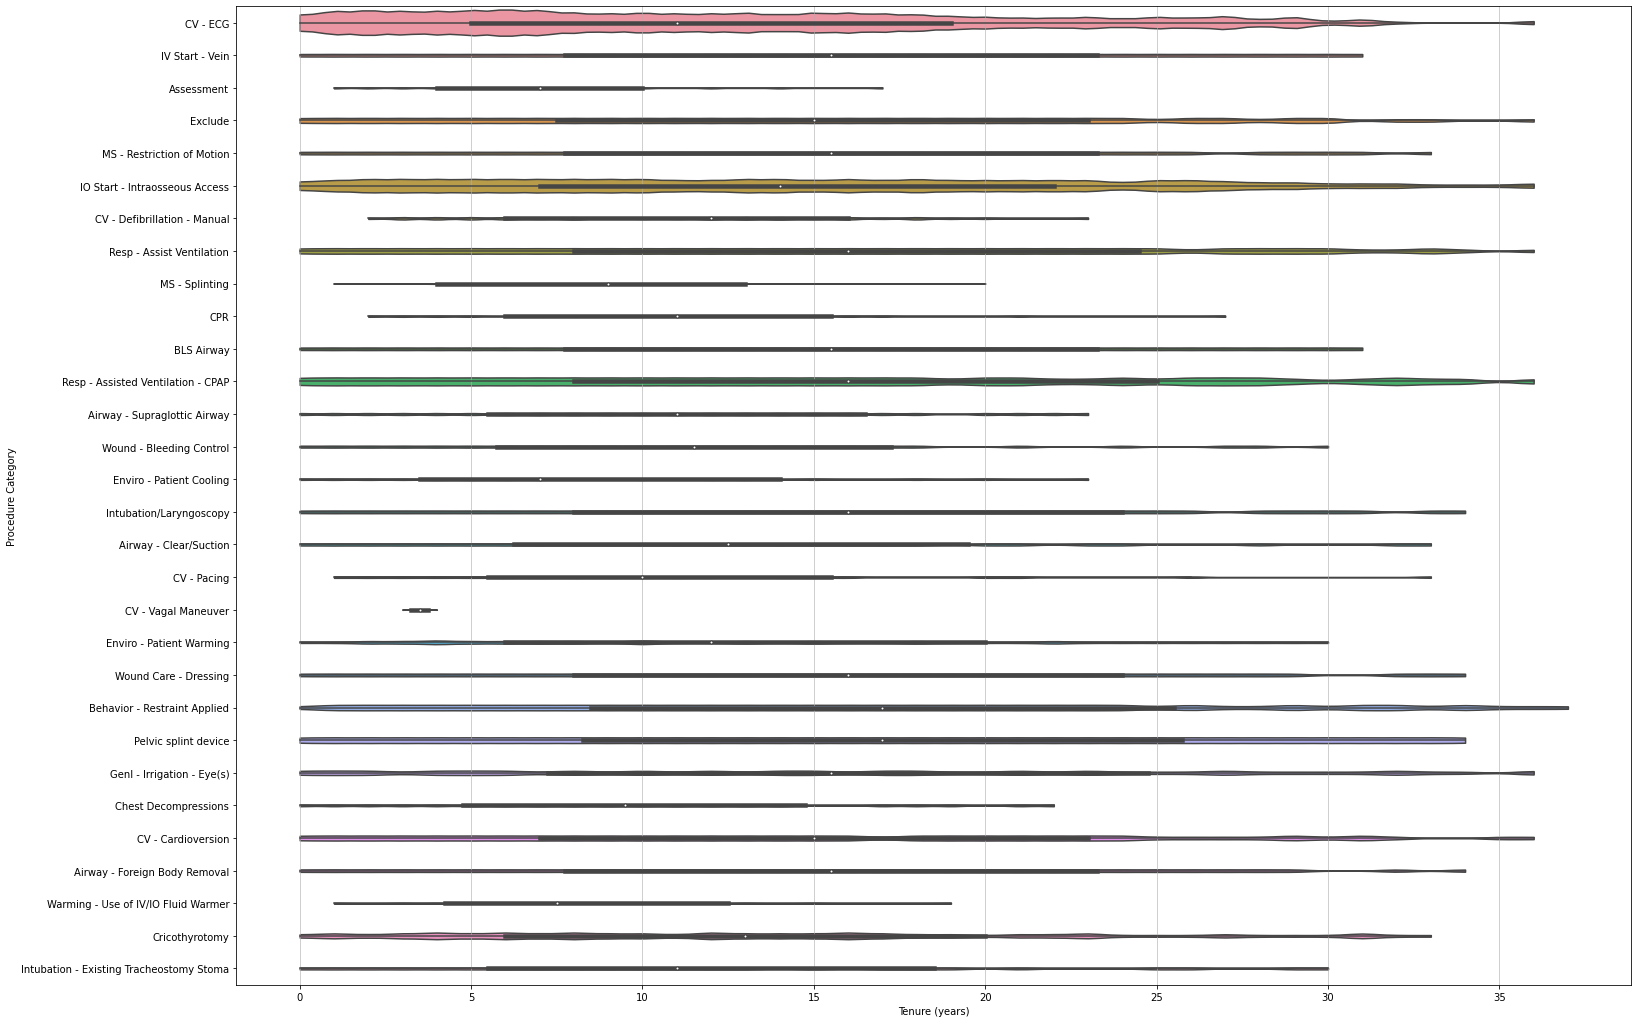

In [91]:
plt.figure(figsize=(25,18))
ax1=sns.violinplot(x="TenureYears",y="ProcedureCatCode",
               data=dfPP_pvt_yr_cat, 
               scale='count',
#              order=OutcomeOrder,
               orient='h',
               bw=.05,
              cut=0);
ax1.grid(axis='x', alpha=.75, which='both')
#ax1.set_xticks(minor=False, ticks=dfProcCatList.index)
ax1.set_yticklabels(dfProcCatList.ProcedureCategory.to_list())
ax1.set_xlabel("Tenure (years)")
ax1.set_ylabel("Procedure Category")
#plt.xticks(rotation=45)

#### Still working on this part

In [93]:
def BuildCodeExcludeDf(dfSource,col_code,exclude_code):
    dfTarget = dfSource[(dfSource[col_code] != exclude_code)]
    return(dfTarget)

def BuildCodeOnlyDf(dfSource,col_code,exclude_code):
    dfTarget = dfSource[(dfSource[col_code] == exclude_code)]
    return(dfTarget)

def BuildTotDf(dfSource,col_code,col_desc):
    dfTarget = dfSource.groupby([col_code,col_desc])[["Procedure_Count"]].sum().reset_index()
    return(dfTarget)

#def BuildQntlTotDf(dfSource,col_code,col_desc):
#    dfTarget = dfSource.groupby([col_code,col_desc])[["Procedure_Count"]].sum().reset_index()
#    return(dfTarget)

In [95]:
dfPP_pvt_yr_cat_excl0 = BuildCodeExcludeDf(dfPP_pvt_yr_cat,'ProcedureCatCode',0),
dfPP_pvt_yr_cat_excl0

(      TenureYears  Procedure_Performed_Code  \
 0             0.0                   7443007   
 1             0.0                  18590009   
 2             0.0                  20655006   
 3             0.0                  22206003   
 4             0.0                  26906007   
 ...           ...                       ...   
 1502         36.0                 392230005   
 1503         36.0                 422618004   
 1505         36.0                 425447009   
 1506         36.0                 428803005   
 1507         37.0                 392230005   
 
                     Procedure_Performed_Description  Procedure_Count  \
 0                  Airway - Oropharyngeal Insertion               23   
 1                CV - Pacing - External or Internal                1   
 2        Wound - Bleeding Control - Tourniquet Used                2   
 3     Wound Care - Dressing - Occlusive Application                2   
 4         Wound Care - Dressing - Pressure Dressing     

In [96]:
dfPP_pvt_yr_cat_excl0_tot = BuildTotDf(dfPP_pvt_yr_cat_excl0,
                                       'Procedure_Performed_Code','Procedure_Performed_Description')

AttributeError: 'tuple' object has no attribute 'groupby'

In [ ]:
dfPP_pvt_yr_cat_excl0.Procedure_Count.sum()

In [ ]:
dfPP_pvt_yr_cat_only0 = BuildCodeOnlyDf(dfPP_pvt_yr_cat,'ProcedureCatCode',0)
dfPP_pvt_yr_cat_only0_tot = BuildTotDf(dfPP_pvt_yr_cat_only0, 
                                       'Procedure_Performed_Code','Procedure_Performed_Description')

In [ ]:
dfPP_pvt_yr_cat_only0.Procedure_Count.sum()

In [ ]:
dfPP_pvt_yr_cat_only5 = BuildCodeOnlyDf(dfPP_pvt_yr_cat,'ProcedureCatCode',5)
dfPP_pvt_yr_cat_only5_tot = BuildTotDf(dfPP_pvt_yr_cat_only5, 
                                       'Procedure_Performed_Code','Procedure_Performed_Description')

In [ ]:
plt.figure(figsize=(25,18))
ax1=sns.violinplot(y="Procedure_Performed_Code",x="TenureYears",
               data=dfPP_pvt_yr_cat_only0, 
               scale='area',
#              order=OutcomeOrder,
               bw=.05,
              cut=0);
ax1.grid(axis='y', alpha=.75, which='both')
ax1.set_yticks(minor=False, ticks=dfPP_pvt_yr_cat_only0.index)
ax1.set_yticklabels(dfPP_pvt_yr_cat_only0.Procedure_Performed_Description.to_list())
ax1.set_ylabel("Procedure Description")


In [ ]:
# build plots that exclude the top two highest procedure counts and only show the next 25 highest

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0

tick_list = ticklst_5000
x_range = xrng_5000

fig,axs=plt.subplots(ncols=1, figsize=(10, 10))
plt.xlim(x_range)
#fig.suptitle("'Excluded' Procedures")
#fig.tight_layout()
#fig.subplots_adjust(top=0.90)

# 
sns.barplot(ax=axs, x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', 
                 #order=dfPP_pvt_yr_cat_only0.Procedure_Performed_Description.to_list(),
                 data=dfPP_pvt_yr_cat_only0_tot )
axs.set_ylabel("Procedure Description")
axs.set_xlabel('Procedure Count')
axs.set_title("'Excluded' Procedures")
axs.set_xticks(minor=True, ticks=tick_list)
axs.grid(axis='both', alpha=.75, which='both')


# show the plots
plt.show()



In [ ]:
# build plot that only shows the procedures in the Assessment category
bar_width = 1.0

tick_list = ticklst_5000
x_range = xrng_5000

fig,axs=plt.subplots(ncols=1, figsize=(10, 4))
plt.xlim(x_range)
#fig.suptitle("'Assessment' Procedures")
#fig.tight_layout()
#fig.subplots_adjust(top=0.90)

# 
sns.barplot(ax=axs, x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette='RdYlGn_r', 
                 #order=dfPP_pvt_yr_cat_only0.Procedure_Performed_Description.to_list(),
                 data=dfPP_pvt_yr_cat_only5_tot )
axs.set_ylabel("Procedure Description")
axs.set_xlabel('Procedure Count')
axs.set_title("'Assessment' Procedures by Tenure (years)")
axs.set_xticks(minor=True, ticks=tick_list)
axs.grid(axis='both', alpha=.75, which='both')


# show the plots
plt.show()

